# Содержание

<br><br>
# Описание проекта

<br><br>
# Загрузка библиотек

In [4]:
!pip install shap -q

In [5]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [6]:
# Настройка отображения графиков
%matplotlib inline
sns.set(font_scale=1.3, style="whitegrid", rc={'figure.figsize': (20, 7)})
pd.set_option('display.max_colwidth', None)

# Установка опции отображения широких датафреймов
pd.set_option('display.max_colwidth', None)

<br><br>
# Шаг 1. Загрузка данных и ознакомление

In [8]:
# загружаем датафреймы и передаем их переменным

market_file = pd.read_csv('/Users/magomedgakaev/Desktop/Проекты/Проект В один клик/market_file.csv', sep=",")
market_money = pd.read_csv('/Users/magomedgakaev/Desktop/Проекты/Проект В один клик/market_money.csv', sep=",")
market_time = pd.read_csv('/Users/magomedgakaev/Desktop/Проекты/Проект В один клик/market_time.csv', sep=",")
money = pd.read_csv('/Users/magomedgakaev/Desktop/Проекты/Проект В один клик/money.csv', sep=";")

In [9]:
# выводим общую информацию

datasets = [market_file, market_money, market_time, money]
datasets_names = ['market_file', 'market_money', 'market_time', 'money']

for i, j in zip(datasets, datasets_names):
    print("="*60, j, "="*60, '\n')
    print('\n')
    display(i.head(6))
    print('\n')
    display(i.info())
    print('\n')
    print(f'Размеры датасета {j}:', i.shape, '\n')

============================================================ market_file ============================================================ 





,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса              

None



Размеры датасета market_file: (1300, 13) 

============================================================ market_money ============================================================ 





,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None



Размеры датасета market_money: (3900, 3) 

============================================================ market_time ============================================================ 





,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None



Размеры датасета market_time: (2600, 3) 

============================================================ money ============================================================ 





,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"
5,215353,"3,95"




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


None



Размеры датасета money: (1300, 2) 



**Выводы:**

1) Названия признаков слишком длинные. Необходимо их сократить для компактности, а также привести к нижнему регистру.
2) В столбце "Прибыль" неверный тип данных. Нужно заменить object на int64.
3) Значения признаков нужно проверить на наличие ошибок, неявных дубликатов, пробелов и пропусков.
4) В датасете market_money каждый индекс повторяется три раза, а в датасете market_time, каждый индекс повторяется по два раза. Целесообразно трансформировать два этих датасета так, чтобы в одной строке указывался один индекс и все значения для этого индекса.
5) Необходимо проверить датасет market_file на наличие полных дубликатов.
6) Можно удалить признак id, так как он является избыточным.
7) Объединяем датафреймы в один общий датафрейм.

<br><br>
# Шаг 2. Предобработка данных

<br><br>
<span style="color:green;">●</span> **2.1 Переименование признаков**. 

Сокращаем названия, приводим текст к нижнему регистру

In [13]:
market_file.columns = [
    'id', 'покупактив', 'тип_сервис', 'разр_сообщать', 'маркетактив_6_мес', \
    'маркетактив_тек_мес', 'длит_ть', 'акц_покупки', 'попул_катег', 'просм_катег_за_визит_сред', \
    'неоплач_продукт_квартал_шт', 'ошибка_сервис', 'страниц_за_визит'
]

market_money.columns = ['id', 'период', 'выручка']

market_time.columns = ['id', 'период', 'минут']

money.columns = ['id', 'прибыль']

<br><br>
<span style="color:green;">●</span> **2.2 Изменение типа данных**. 

Признаку **прибыль** подходит числовой тип данных. Поэтому заменяем тип object на тип float64.

In [15]:
# изменяем тип данных

money['прибыль'] = (money['прибыль'].str.replace(',', '.'))
money['прибыль'] = pd.to_numeric(money['прибыль'])

<br><br>
<span style="color:green;">●</span> **2.3 Поиск неявных дубликатов и корректировка грамматических ошибок**.

Неявные дубликаты и ошибки будем искать в категориальных данных. В числовых данных нет смысла их искать.

In [17]:
for dataset, name in zip(datasets, datasets_names):
    print(f"\n{'='*30} Уникальные категориальные значения для датасета {name} {'='*30}\n")
    
    # Определяем категориальные колонки
    categorical_cols = dataset.select_dtypes(include=['object', 'category']).columns
    
    if categorical_cols.empty:
        print(f"В датасете {name} нет категориальных данных.\n")
    else:
        for col in categorical_cols:
            print(f"Уникальные значения признака '{col}': {dataset[col].unique()}\n")


============================== Уникальные категориальные значения для датасета market_file ==============================

Уникальные значения признака 'покупактив': ['Снизилась' 'Прежний уровень']

Уникальные значения признака 'тип_сервис': ['премиум' 'стандартт' 'стандарт']

Уникальные значения признака 'разр_сообщать': ['да' 'нет']

Уникальные значения признака 'попул_катег': ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


============================== Уникальные категориальные значения для датасета market_money ==============================

Уникальные значения признака 'период': ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


============================== Уникальные категориальные значения для датасета market_time ==============================

Уникальные значения признака 'период': ['текущий_месяц' 'предыдцщий_месяц']


============================== Ун

In [18]:
# Функция для обработки строковых значений
def clean_string(value):
    if isinstance(value, str):  # Проверяем, что значение строковое
        value = value.lower()  # Приводим к нижнему регистру
        value = value.replace('прежний уровень', 'не снизилась')
        value = value.replace('аксесуары', 'аксессуары')  # Исправляем грамматическую ошибку
        value = value.replace('стандартт', 'стандарт')  # Исправляем ошибку в слове "стандарт"
        value = value.replace('предыдцщий_месяц', 'предыдущий_месяц')  # Исправляем ошибку в слове "предыдущий"
    return value

# Применяем функцию ко всем датасетам, где есть категориальные значения
for df in [market_file, market_money, market_time]:
    for column in df.select_dtypes(include=['object']).columns:  # Только текстовые столбцы
        df[column] = df[column].apply(clean_string)

In [19]:
for dataset, name in zip(datasets, datasets_names):
    print(f"\n{'='*30} Уникальные категориальные значения для датасета {name} {'='*30}\n")
    
    # Определяем категориальные колонки
    categorical_cols = dataset.select_dtypes(include=['object', 'category']).columns
    
    if categorical_cols.empty:
        print(f"В датасете {name} нет категориальных данных.\n")
    else:
        for col in categorical_cols:
            print(f"Уникальные значения признака '{col}': {dataset[col].unique()}\n")


============================== Уникальные категориальные значения для датасета market_file ==============================

Уникальные значения признака 'покупактив': ['снизилась' 'не снизилась']

Уникальные значения признака 'тип_сервис': ['премиум' 'стандарт']

Уникальные значения признака 'разр_сообщать': ['да' 'нет']

Уникальные значения признака 'попул_катег': ['товары для детей' 'домашний текстиль' 'косметика и аксессуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']


============================== Уникальные категориальные значения для датасета market_money ==============================

Уникальные значения признака 'период': ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


============================== Уникальные категориальные значения для датасета market_time ==============================

Уникальные значения признака 'период': ['текущий_месяц' 'предыдущий_месяц']


============================== Уникальные катег

<br><br>
<span style="color:green;">●</span> **2.4 Трансформация датасетов market_money и market_time**.

In [21]:
market_money = pd.pivot_table(market_money, index='id', columns='период', values='выручка')

# Убираем имя уровня 'период'
market_money.columns.name = None

# Сбрасываем индекс, чтобы сделать таблицу плоской
market_money.reset_index(inplace=True)

market_money.columns = ['id', 'пред_мес_выруч', 'препред_мес_выруч', 'тек_мес_выруч']

market_money = market_money[['id', 'препред_мес_выруч', 'пред_мес_выруч', 'тек_мес_выруч']]

# Проверяем результат
print(f'Размер датасета: {market_money.shape}')
display(market_money.head(3))

Размер датасета: (1300, 4)


,id,препред_мес_выруч,пред_мес_выруч,тек_мес_выруч
0,215348,0.0,0.0,3293.1
1,215349,4472.0,5216.0,4971.6
2,215350,4826.0,5457.5,5058.4


In [22]:
market_time = pd.pivot_table(market_time, index='id', columns='период', values='минут')

# Убираем имя уровня 'период'
market_time.columns.name = None

# Сбрасываем индекс, чтобы сделать таблицу плоской
market_time.reset_index(inplace=True)

market_time.columns = ['id', 'пред_мес_мин', 'тек_мес_мин']

# Проверяем результат
print(f'Размер датасета: {market_time.shape}')
display(market_time.head(3))

Размер датасета: (1300, 3)


,id,пред_мес_мин,тек_мес_мин
0,215348,13.0,14.0
1,215349,12.0,10.0
2,215350,8.0,13.0


<br><br>
<span style="color:green;">●</span> **2.5 Удаление полных дубликатов**.

In [24]:
# Находим дубликаты, исключая столбец 'id'
duplicates = market_file[market_file.drop(['id'], axis=1).duplicated()]

print(f"Количество дубликатов: {len(duplicates)}")

Количество дубликатов: 11


In [25]:
# Получаем список значений 'id', связанных с дубликатами
duplicate_ids = duplicates['id'].unique()
print(f"ID для удаления: {duplicate_ids}")

ID для удаления: [215895 215896 215897 215898 215899 215900 215901 215902 215903 215904
 215905]


In [26]:
# Удаляем строки с этими 'id' из всех датафреймов
market_file = market_file[~market_file['id'].isin(duplicate_ids)]
market_money = market_money[~market_money['id'].isin(duplicate_ids)]
market_time = market_time[~market_time['id'].isin(duplicate_ids)]
money = money[~money['id'].isin(duplicate_ids)]

In [27]:
# Восстанавливаем индексы во всех датафреймах
market_file.reset_index(drop=True, inplace=True)
market_money.reset_index(drop=True, inplace=True)
market_time.reset_index(drop=True, inplace=True)
money.reset_index(drop=True, inplace=True)

<br><br>
<span style="color:green;">●</span> **2.6 Удаление признака "id"**.

In [29]:
# Удаляем колонку 'id' из всех датасетов
market_file = market_file.drop(columns='id')
market_money = market_money.drop(columns='id')
market_time = market_time.drop(columns='id')
money = money.drop(columns='id')

<br><br>
<span style="color:green;">●</span> **2.7 Объединение датасетов**.

In [31]:
market_full = pd.concat([market_file, market_time, market_money, money], axis=1)

<br><br>
<span style="color:green;">●</span> **2.8 Проверка на наличие пропусков**.

In [33]:
print(market_full.isnull().sum())

покупактив                    0
тип_сервис                    0
разр_сообщать                 0
маркетактив_6_мес             0
маркетактив_тек_мес           0
длит_ть                       0
акц_покупки                   0
попул_катег                   0
просм_катег_за_визит_сред     0
неоплач_продукт_квартал_шт    0
ошибка_сервис                 0
страниц_за_визит              0
пред_мес_мин                  0
тек_мес_мин                   0
препред_мес_выруч             0
пред_мес_выруч                0
тек_мес_выруч                 0
прибыль                       0
dtype: int64


<br><br>
<span style="color:green;">●</span> **2.9 Выводим общую информацию и делаем выводы по шагу 2**.

In [35]:
display(market_full.head())
display(market_full.info())
print(f"Размер датасета: {market_full.shape}")

,покупактив,тип_сервис,разр_сообщать,маркетактив_6_мес,маркетактив_тек_мес,длит_ть,акц_покупки,попул_катег,просм_катег_за_визит_сред,неоплач_продукт_квартал_шт,ошибка_сервис,страниц_за_визит,пред_мес_мин,тек_мес_мин,препред_мес_выруч,пред_мес_выруч,тек_мес_выруч,прибыль
0,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5,13.0,14.0,0.0,0.0,3293.1,0.98
1,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,12.0,10.0,4472.0,5216.0,4971.6,4.16
2,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,8.0,13.0,4826.0,5457.5,5058.4,3.13
3,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,11.0,13.0,4793.0,6158.0,6610.4,4.87
4,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,8.0,11.0,4594.0,5807.5,5872.5,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   покупактив                  1289 non-null   object 
 1   тип_сервис                  1289 non-null   object 
 2   разр_сообщать               1289 non-null   object 
 3   маркетактив_6_мес           1289 non-null   float64
 4   маркетактив_тек_мес         1289 non-null   int64  
 5   длит_ть                     1289 non-null   int64  
 6   акц_покупки                 1289 non-null   float64
 7   попул_катег                 1289 non-null   object 
 8   просм_катег_за_визит_сред   1289 non-null   int64  
 9   неоплач_продукт_квартал_шт  1289 non-null   int64  
 10  ошибка_сервис               1289 non-null   int64  
 11  страниц_за_визит            1289 non-null   int64  
 12  пред_мес_мин                1289 non-null   float64
 13  тек_мес_мин                 1289 

None

Размер датасета: (1289, 18)


**Выводы:**

1) Названия признаков сокращены, а также приведены к нижнему регистру.
2) Тип признака "прибыль" изменен на float64.
3) Исправлены грамматические ошибки, а также выявлены и заменены неявные дубикаты.
4) Датасеты market_money и market_time трансформированы и объеденены с остальными датасетами в один общий датасет.
5) Из датасета market_file удалены полные дубликаты.
6) Удален признак id, так как он является избыточным.

<br><br>
# Шаг 3. Исследовательский анализ данных

<br><br>
<span style="color:green;">●</span> **3.1 Отбор активных клиентов**.

Отбираем клиентов, которые покупали хоть что-нибудь в течение трех месяцев. Следовательно, нужно избавиться от клиентов, у которых стоят нули хотя бы в одном из признаков:

- препред_мес_выруч;
- пред_мес_выруч;
- тек_мес_выруч.

In [40]:
# указываем столбцы, которые хотим проверить
columns_to_check = ["препред_мес_выруч", "пред_мес_выруч", "тек_мес_выруч"]

In [41]:
# фильтруем строки, где хотя бы одно значение равно нулю
rows_with_zeros = market_full[(market_full[columns_to_check] == 0).any(axis=1)]

# выводим результат для ознакомления
display(rows_with_zeros)

,покупактив,тип_сервис,разр_сообщать,маркетактив_6_мес,маркетактив_тек_мес,длит_ть,акц_покупки,попул_катег,просм_катег_за_визит_сред,неоплач_продукт_квартал_шт,ошибка_сервис,страниц_за_визит,пред_мес_мин,тек_мес_мин,препред_мес_выруч,пред_мес_выруч,тек_мес_выруч,прибыль
0,снизилась,премиум,да,3.4,5,121,0.0,товары для детей,6,2,1,5,13.0,14.0,0.0,0.0,3293.1,0.98
9,снизилась,стандарт,да,3.9,5,154,0.0,техника для красоты и здоровья,3,3,9,5,12.0,6.0,0.0,0.0,5986.3,4.66
11,снизилась,стандарт,да,4.6,5,110,0.0,домашний текстиль,4,2,4,2,13.0,11.0,0.0,0.0,4735.0,5.08


Найдено 3 клиента, которые ничего не покупали в двух предыдущих месяцах. 

In [43]:
# фильтруем строки, оставляя только те, где во всех указанных столбцах значения не равны нулю
market_full = market_full[(market_full[columns_to_check] != 0).all(axis=1)]

# восстанавливаем индексы во всех датафреймах
market_full.reset_index(drop=True, inplace=True)

<br><br>
<span style="color:green;">●</span> **3.2 Исследовательский анализ количественных данных**.

In [45]:
quan_columns = [
    'маркетактив_6_мес', 
    'длит_ть', 
    'акц_покупки',
    'страниц_за_визит', 
    'пред_мес_мин', 
    'тек_мес_мин', 
    'препред_мес_выруч',
    'пред_мес_выруч', 
    'тек_мес_выруч', 
    'прибыль'
]

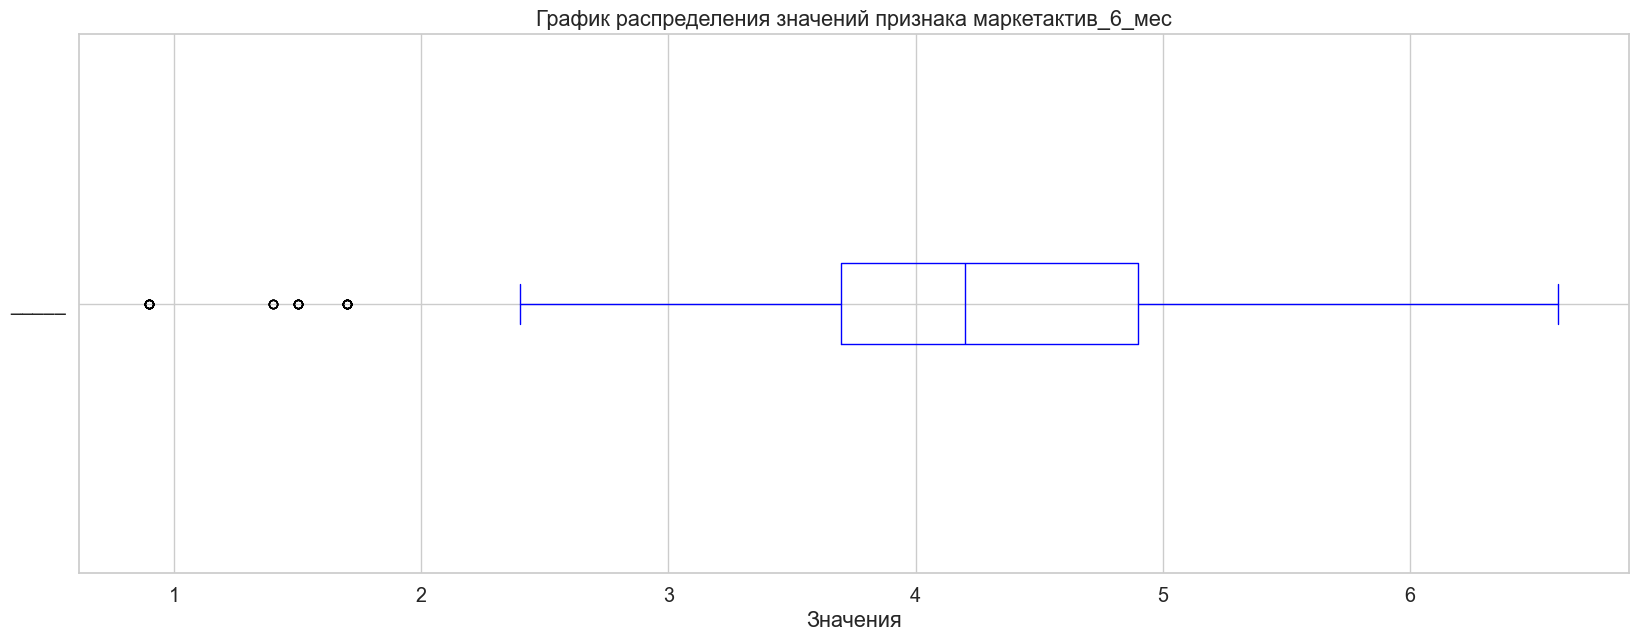

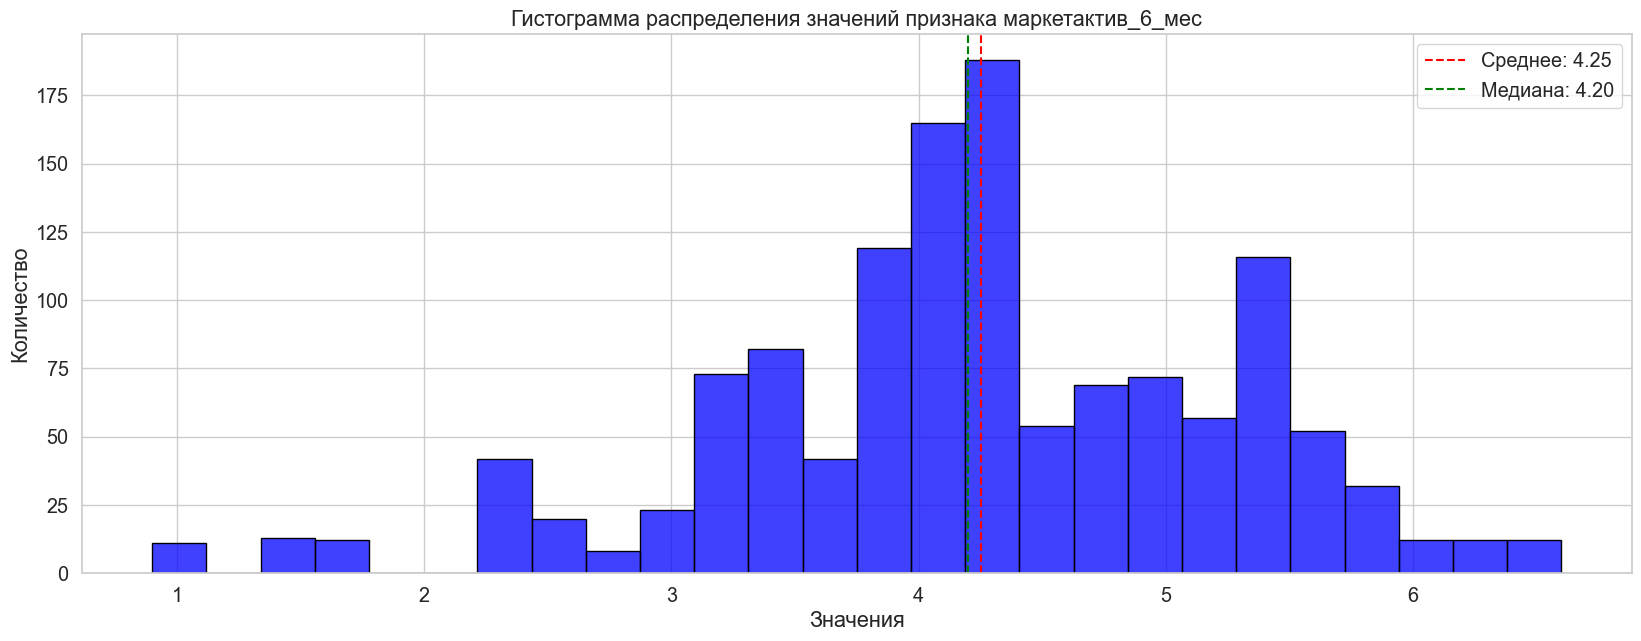

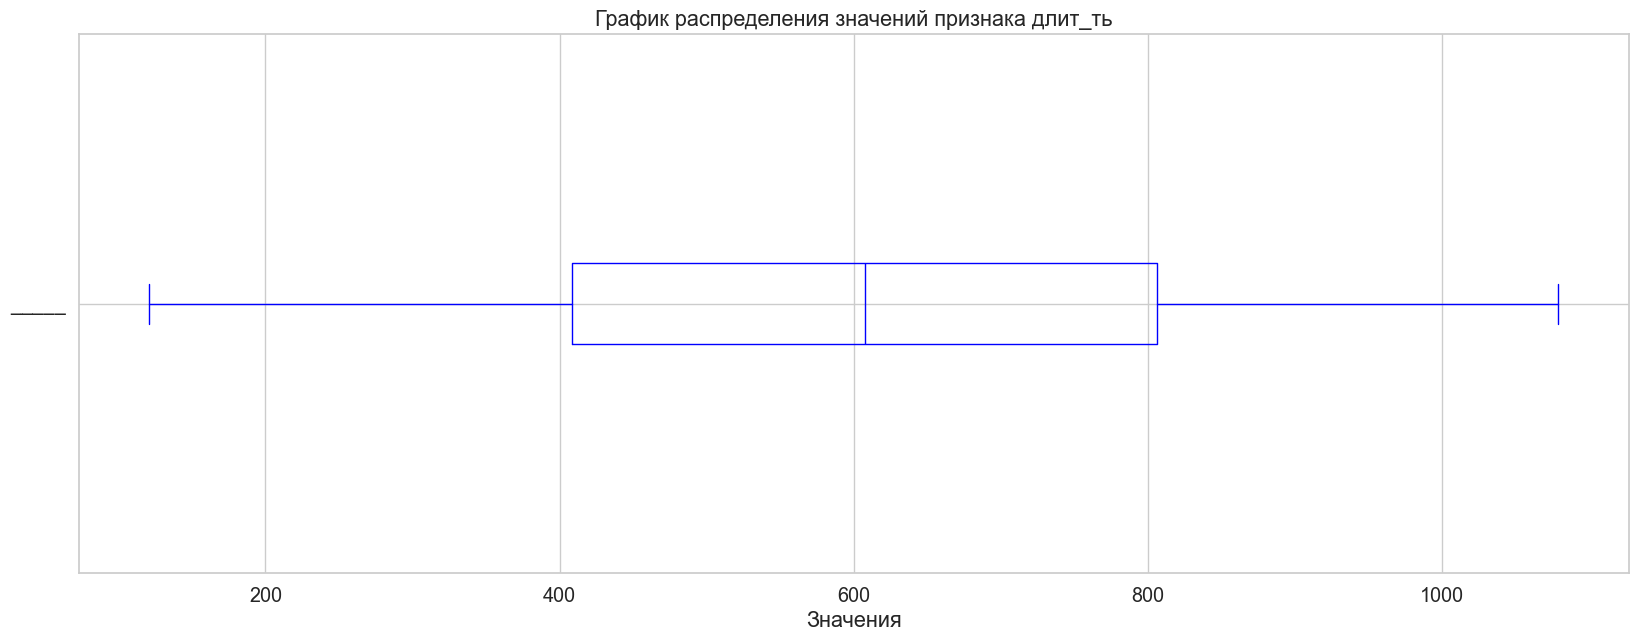

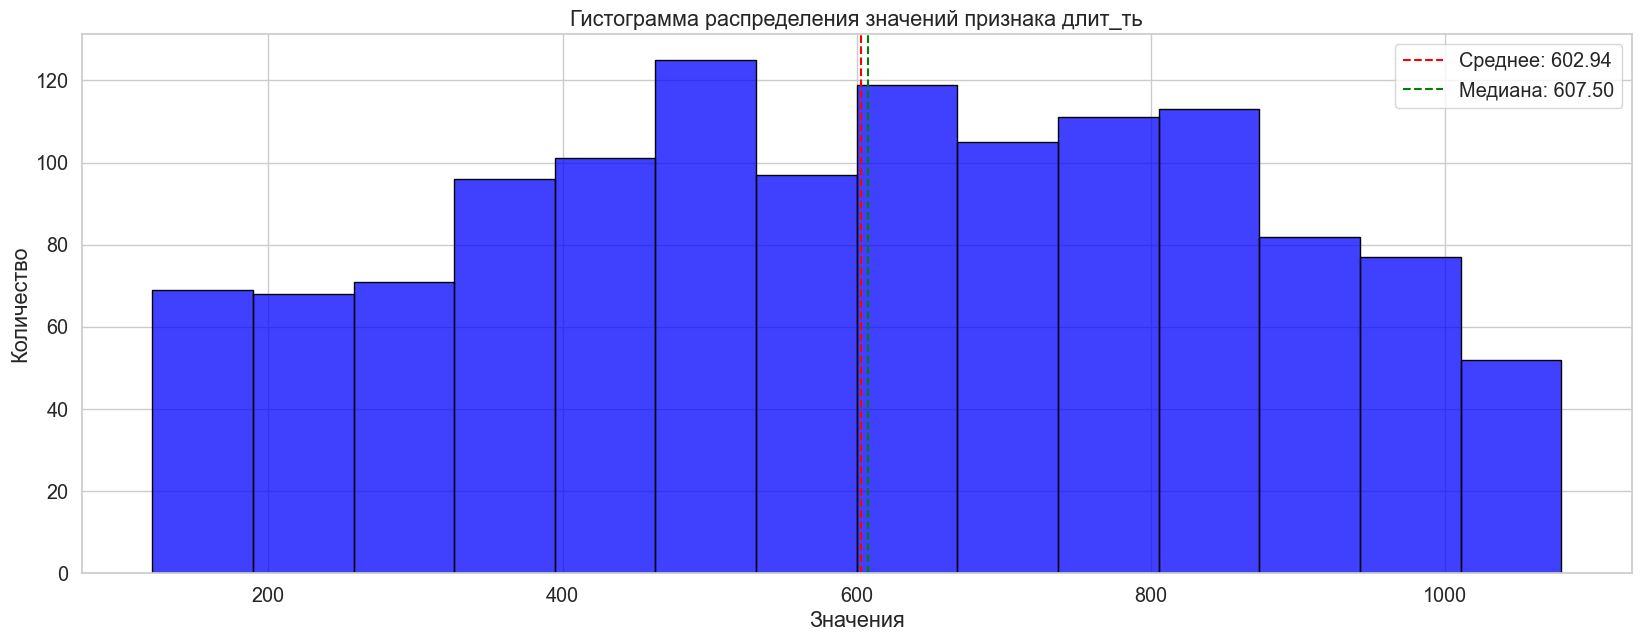

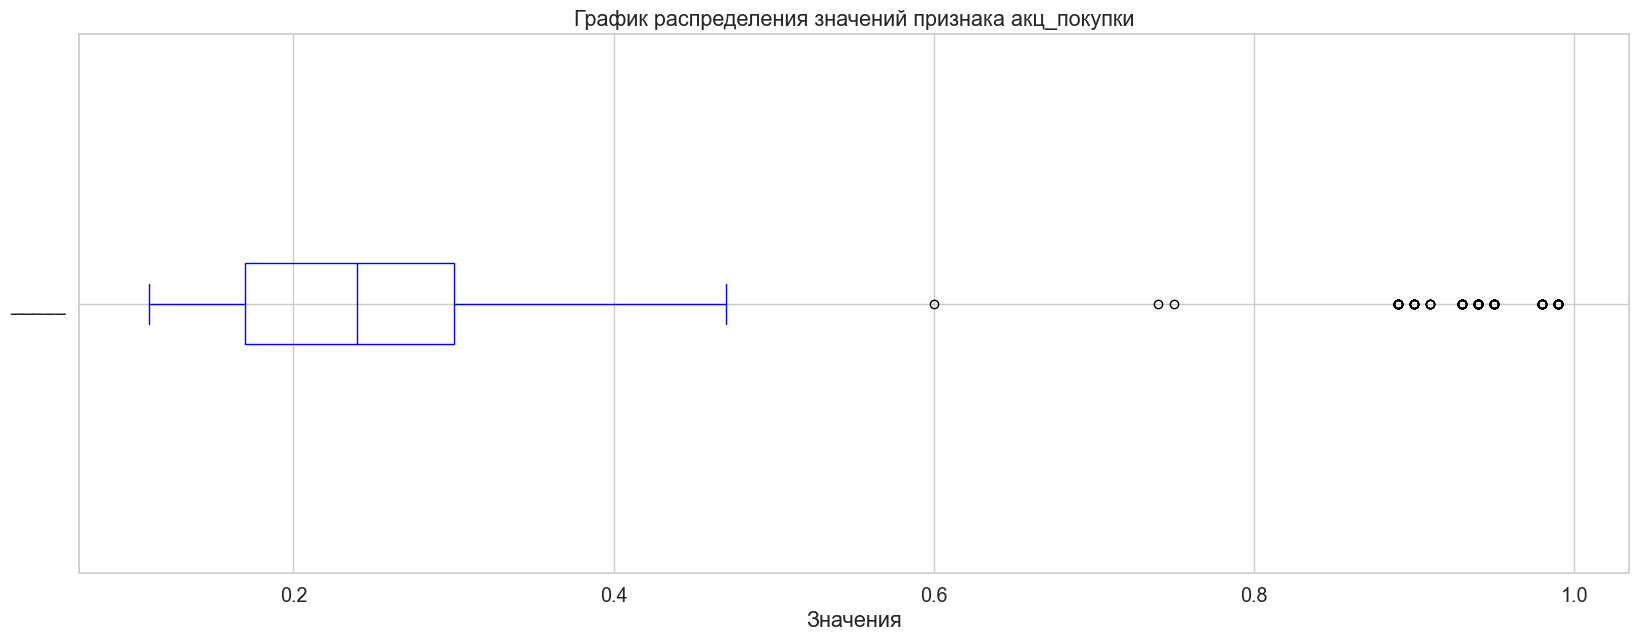

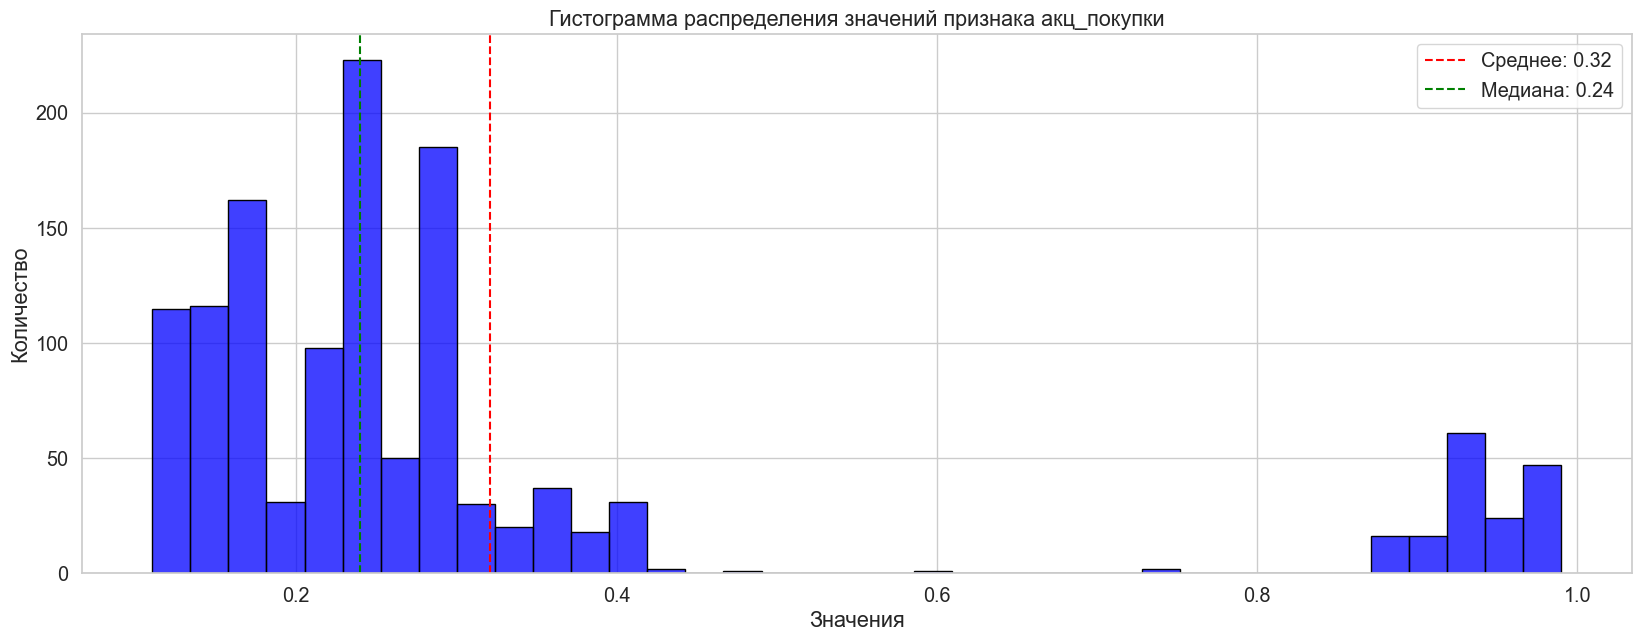

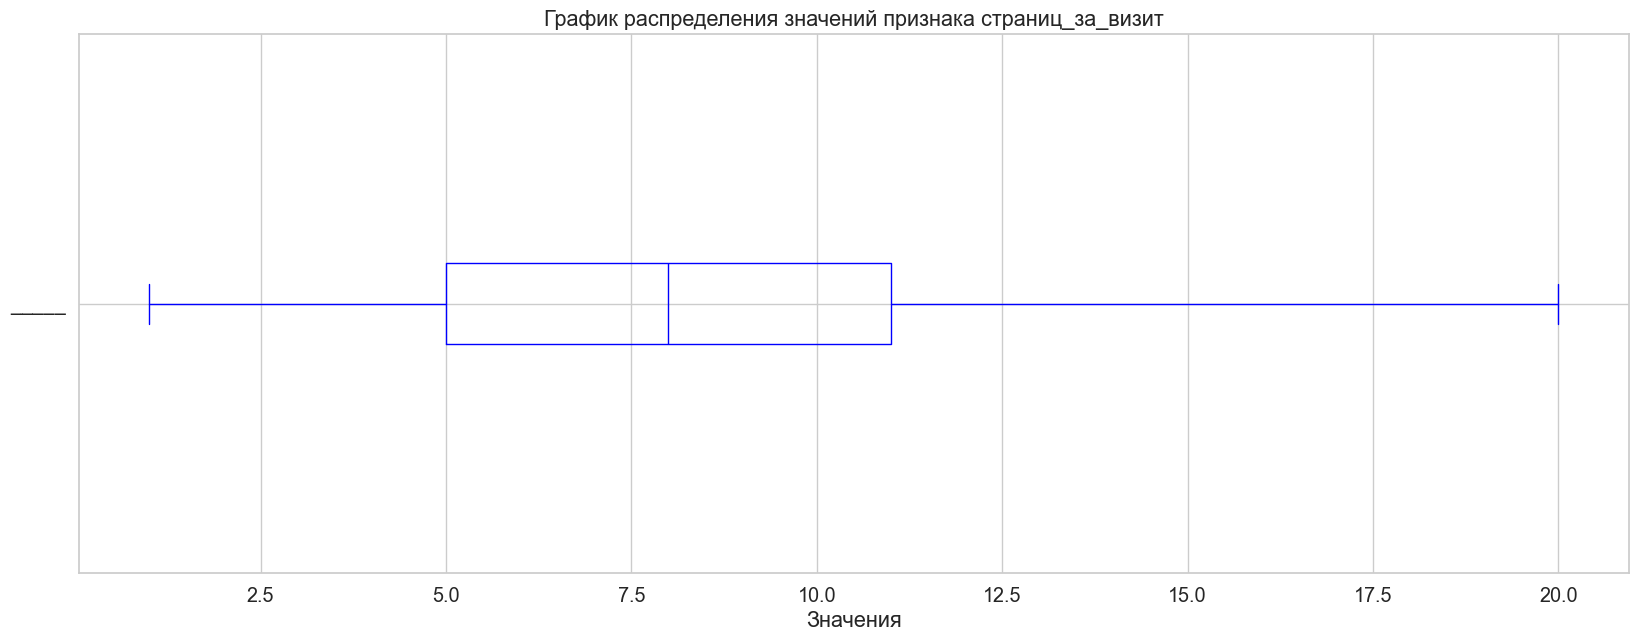

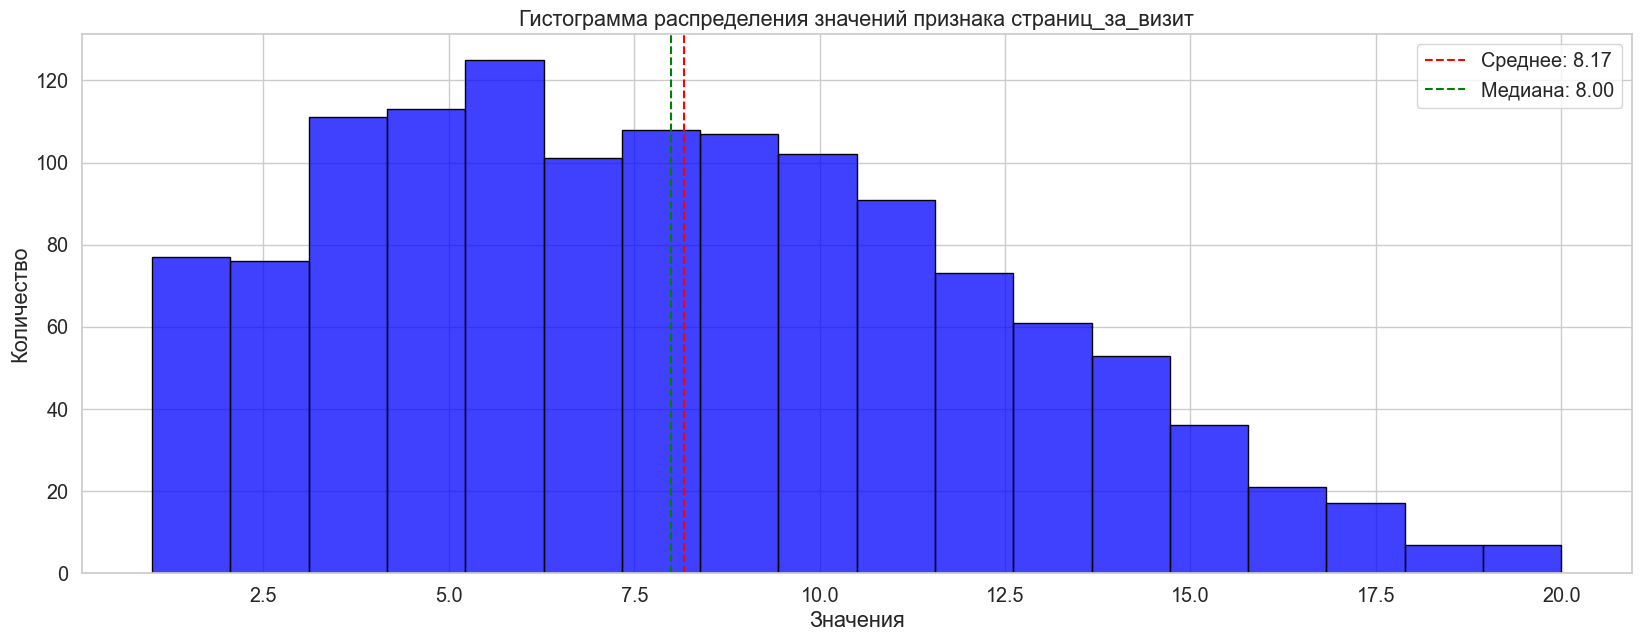

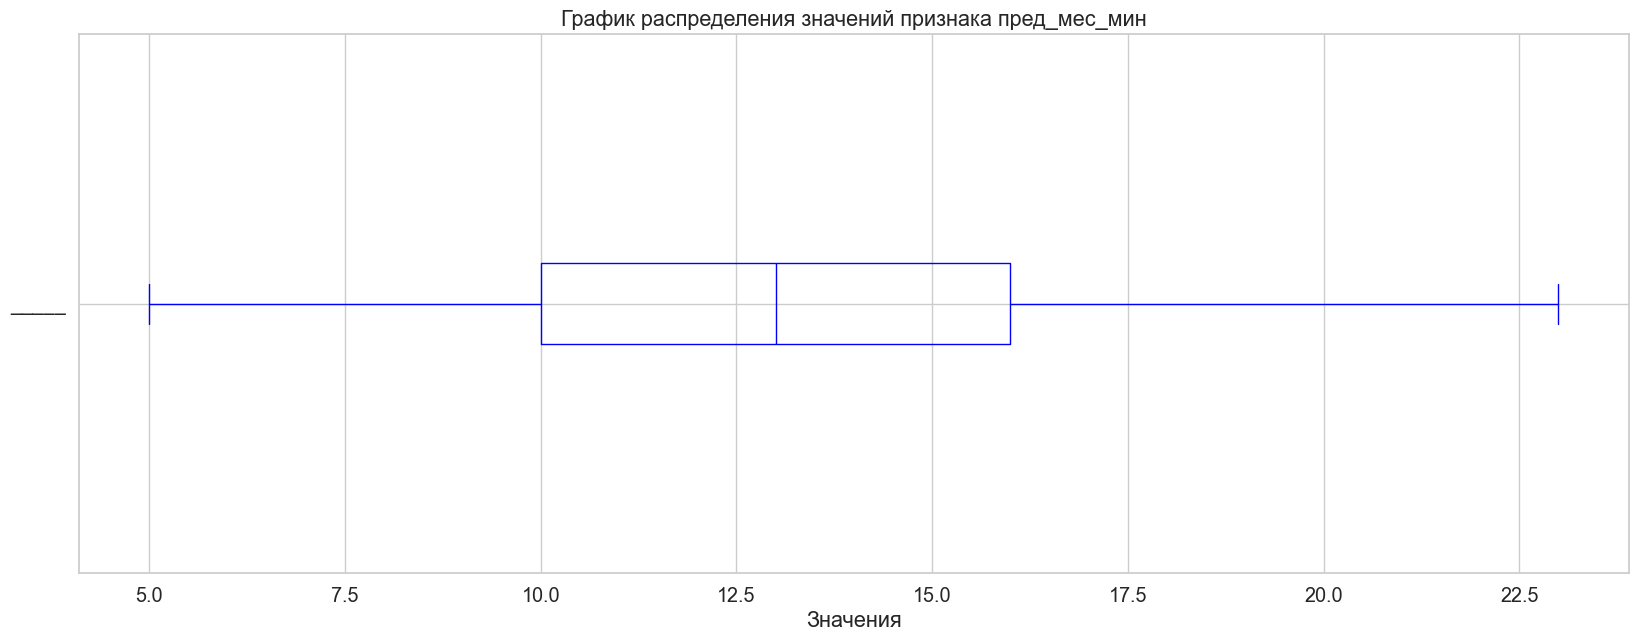

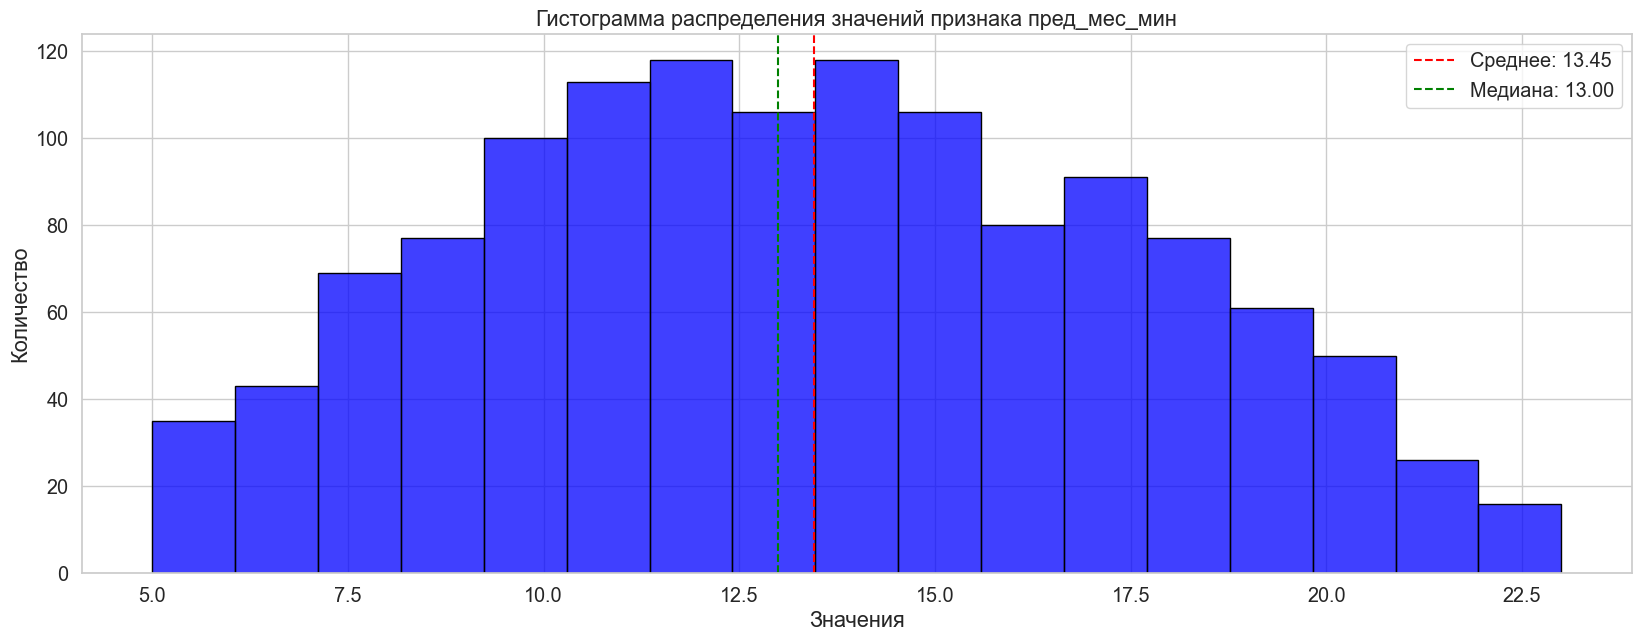

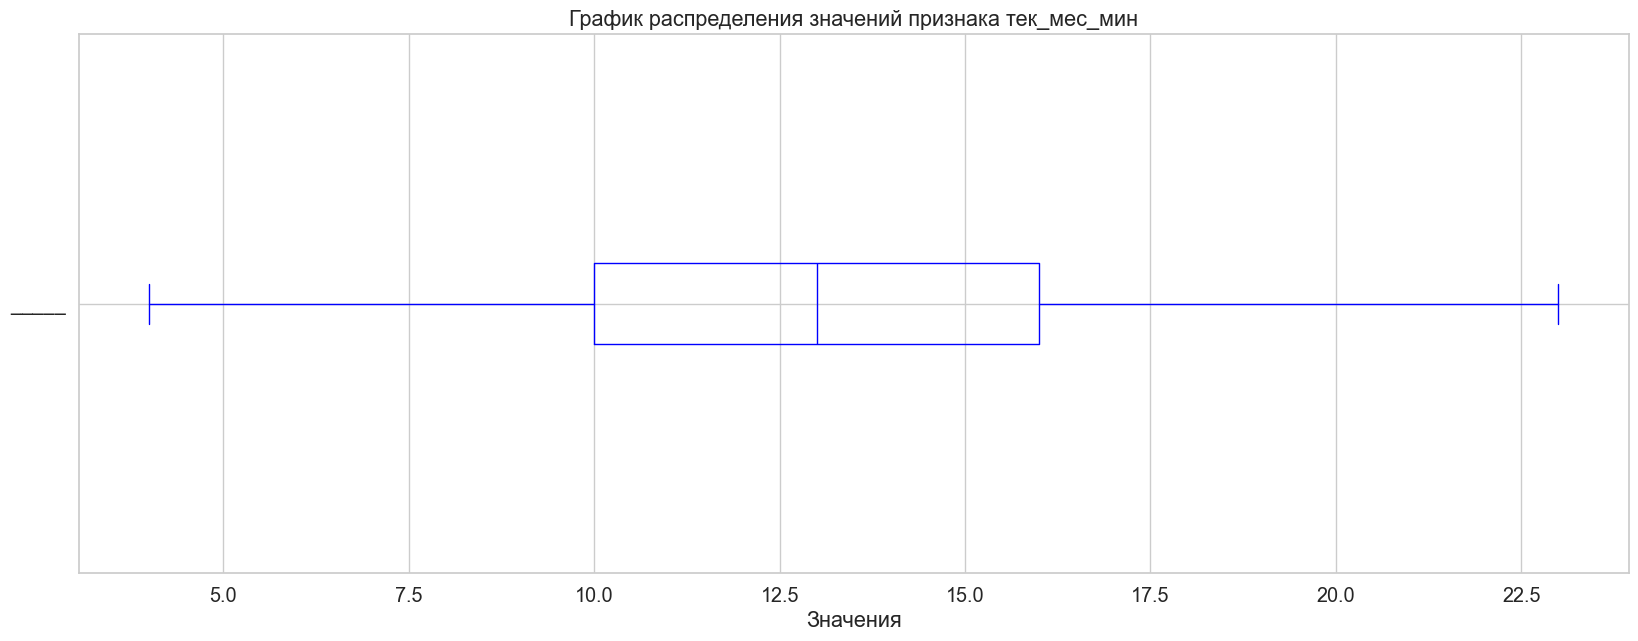

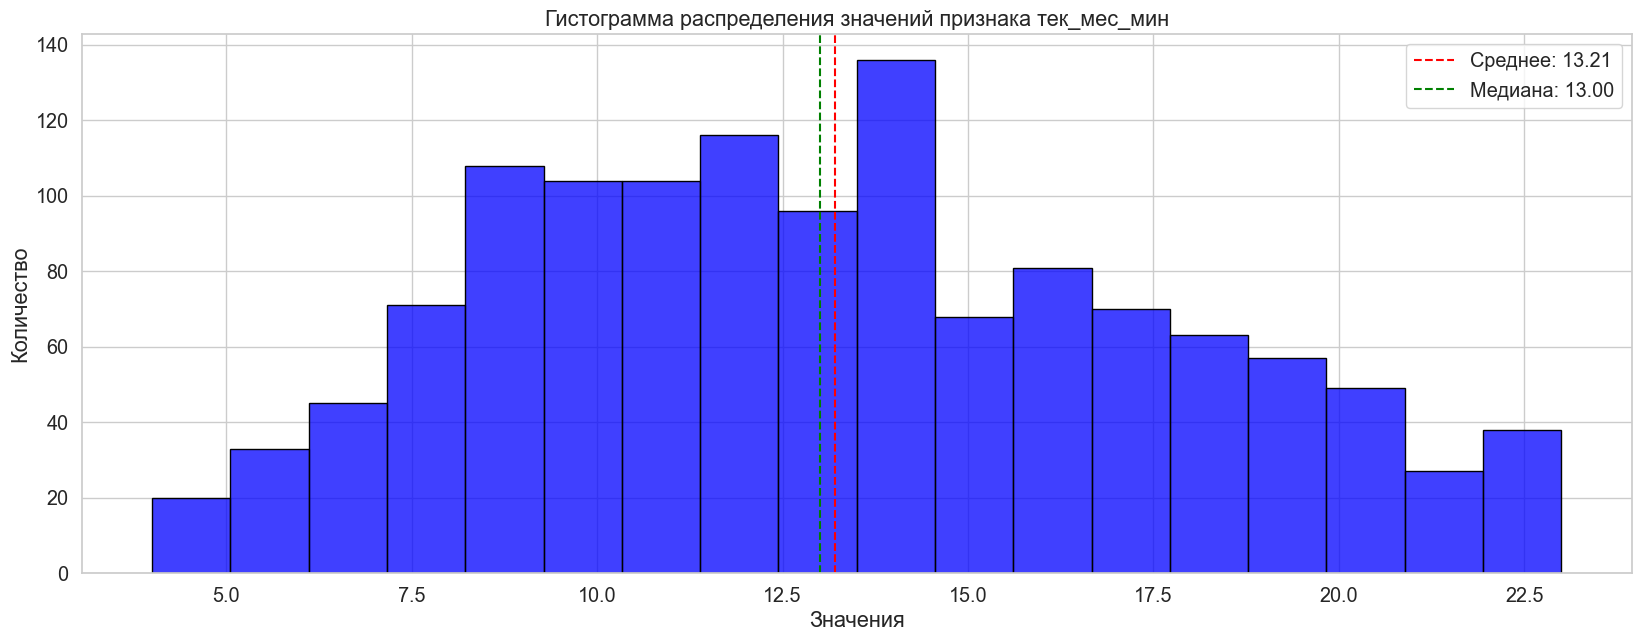

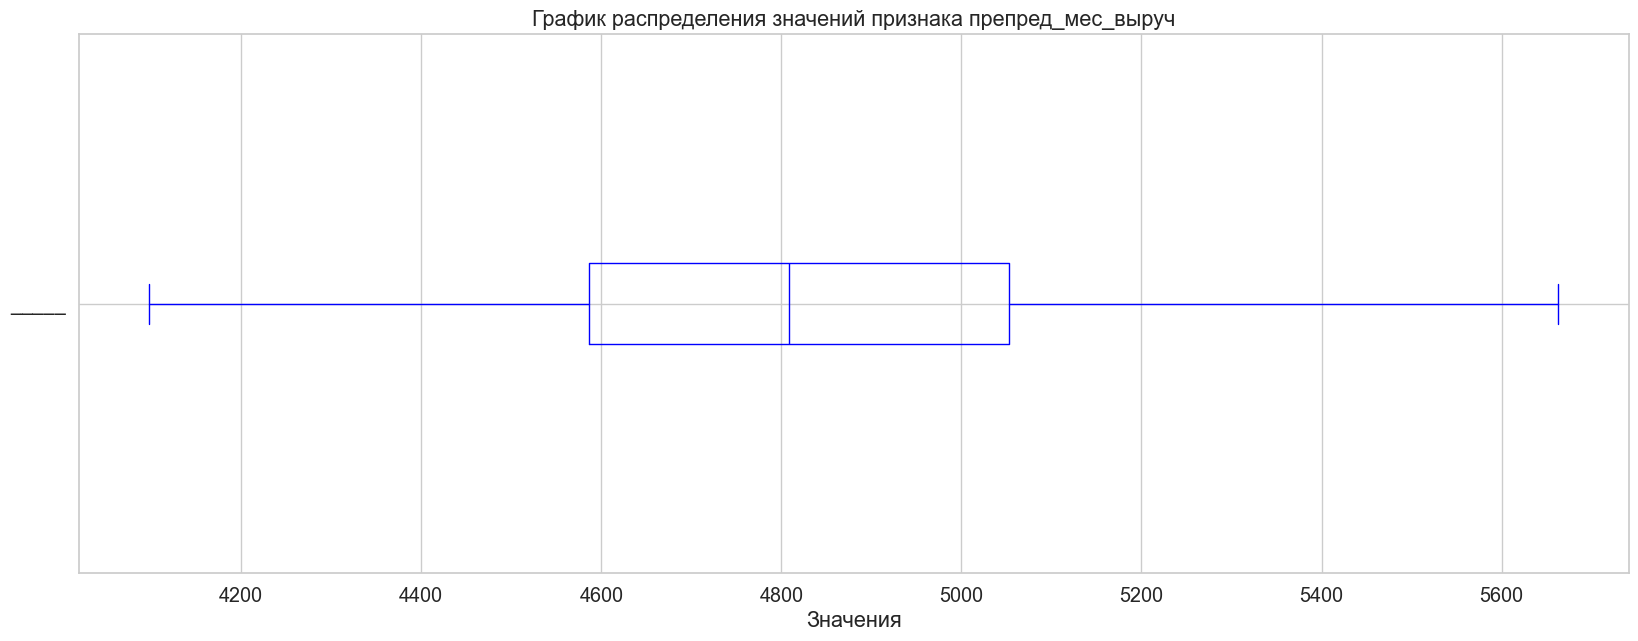

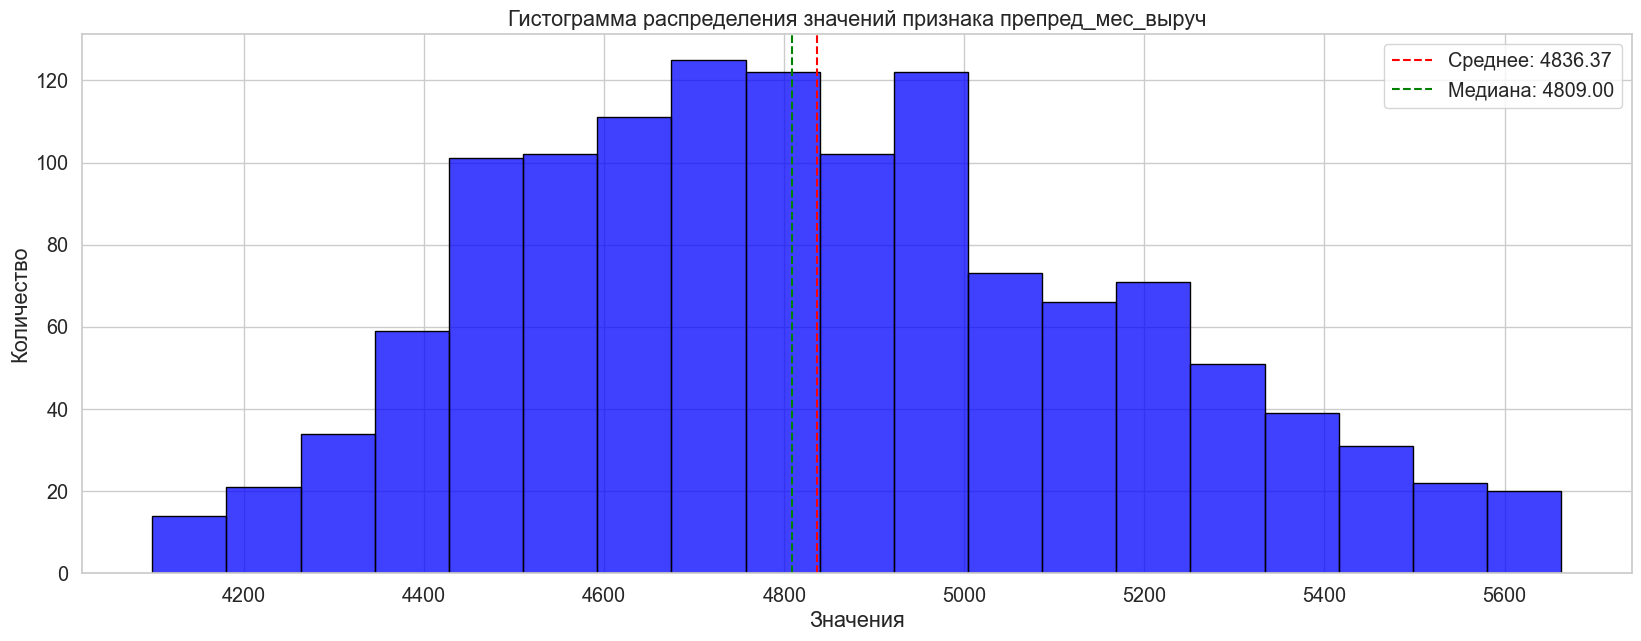

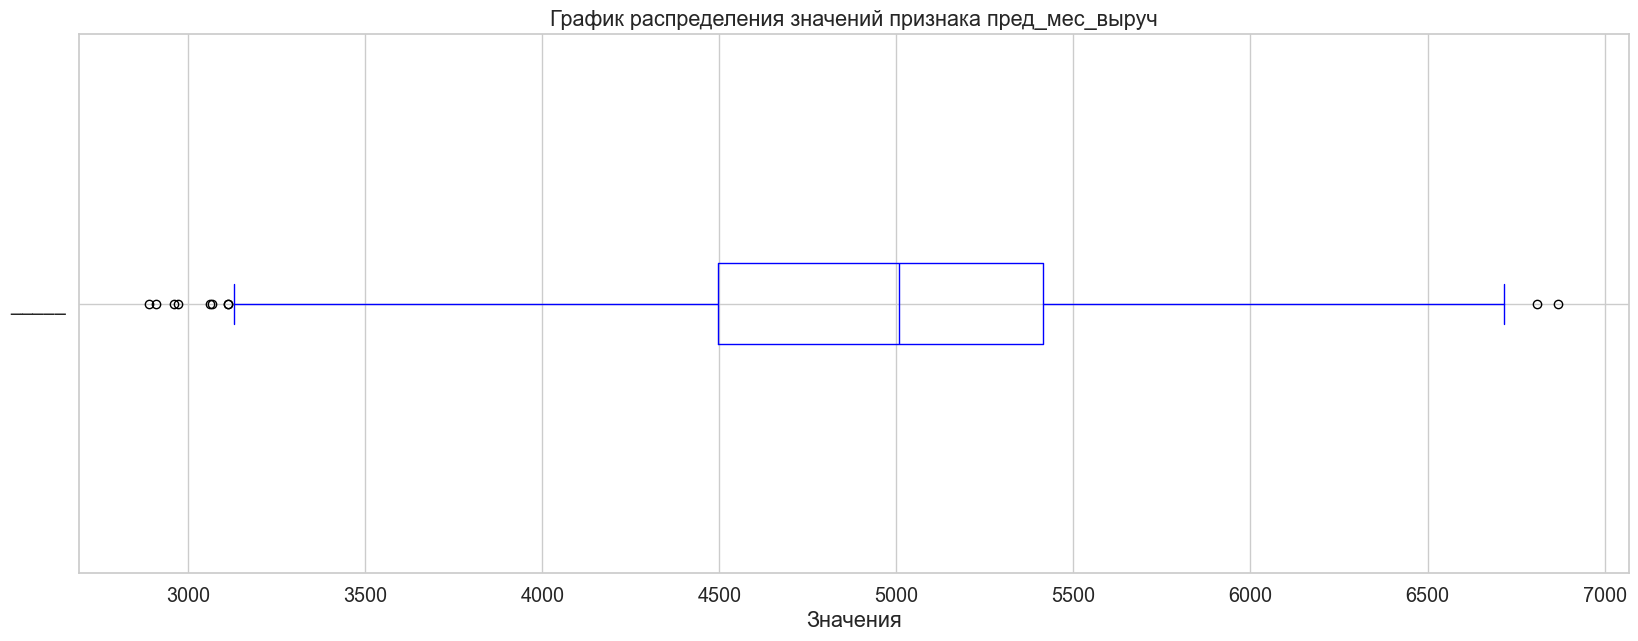

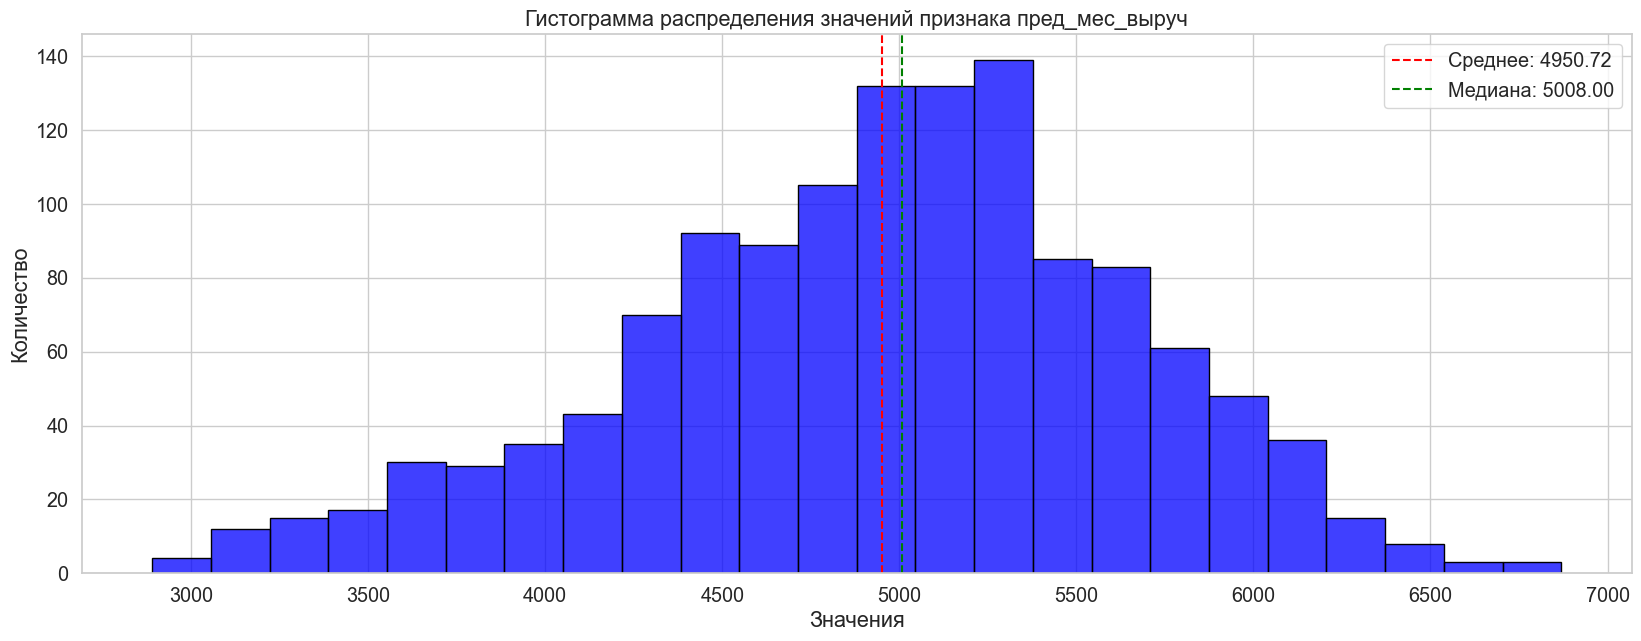

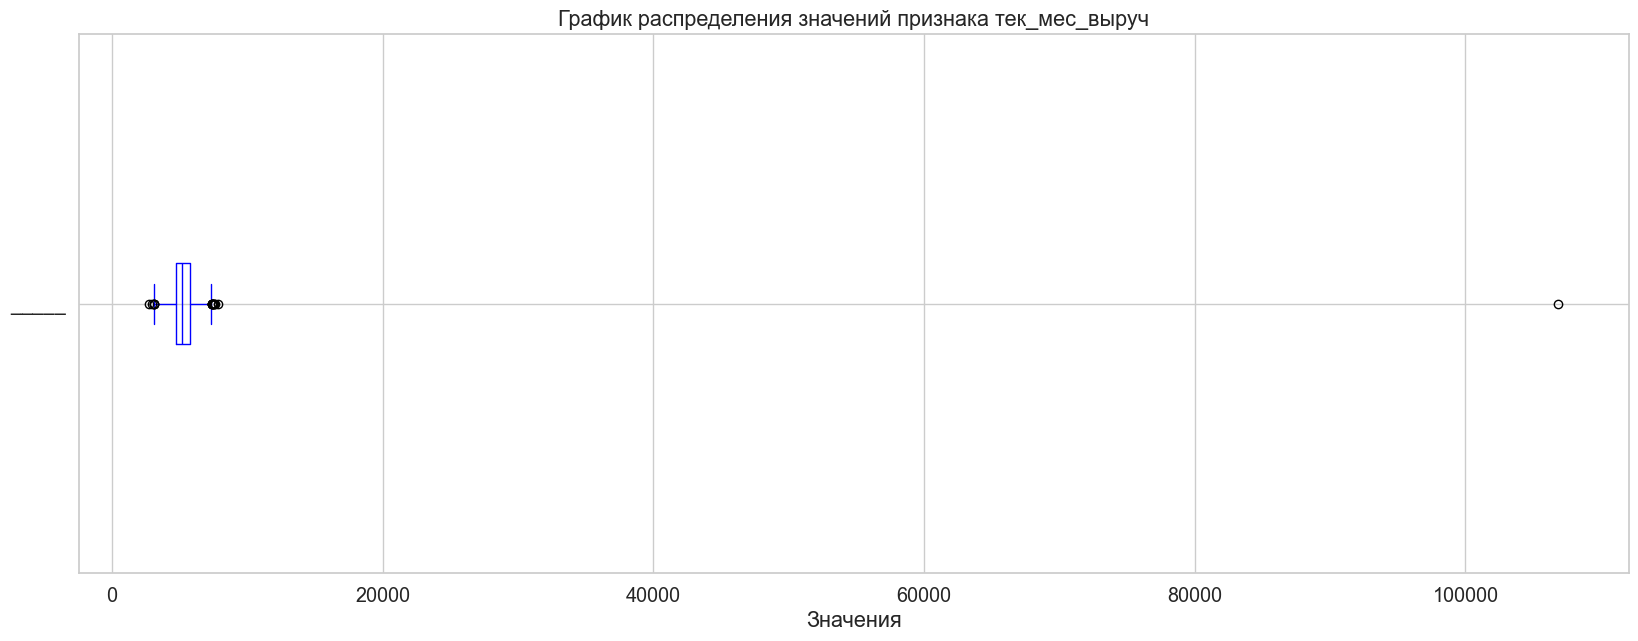

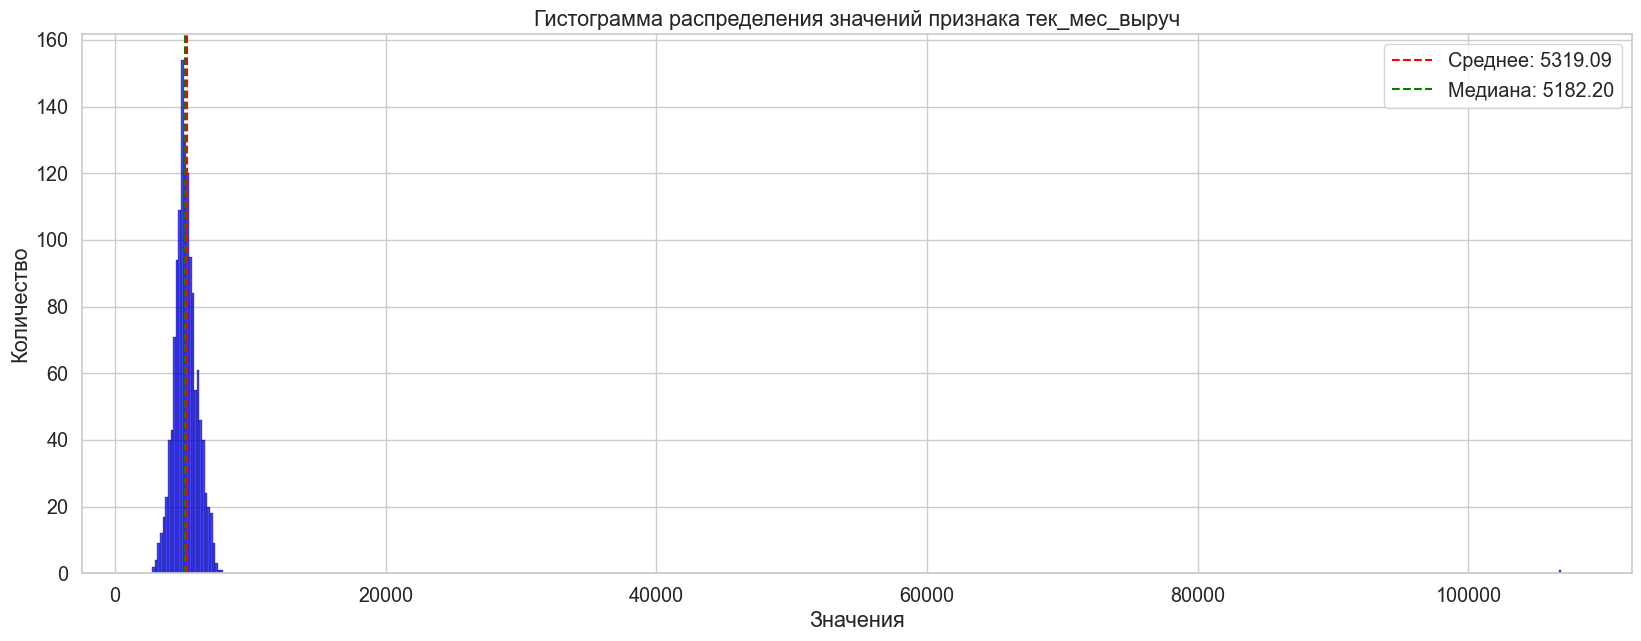

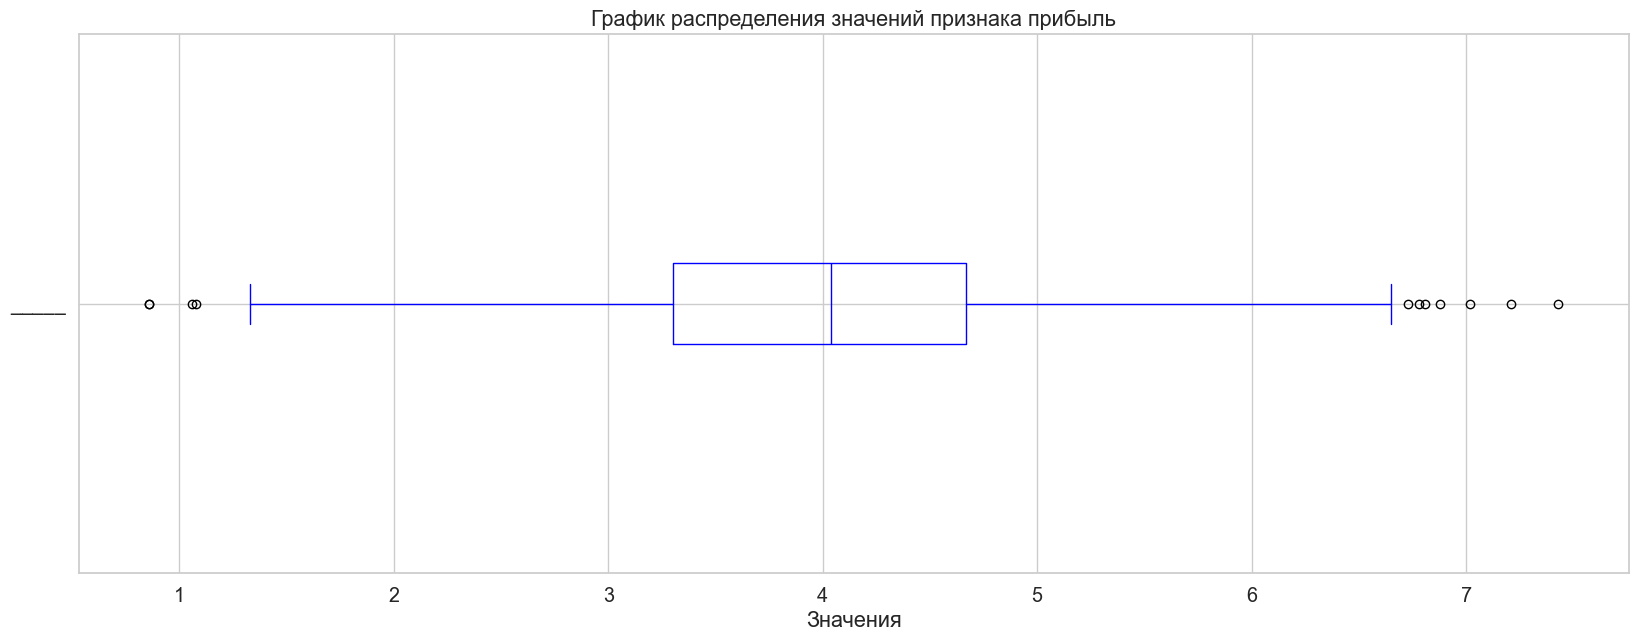

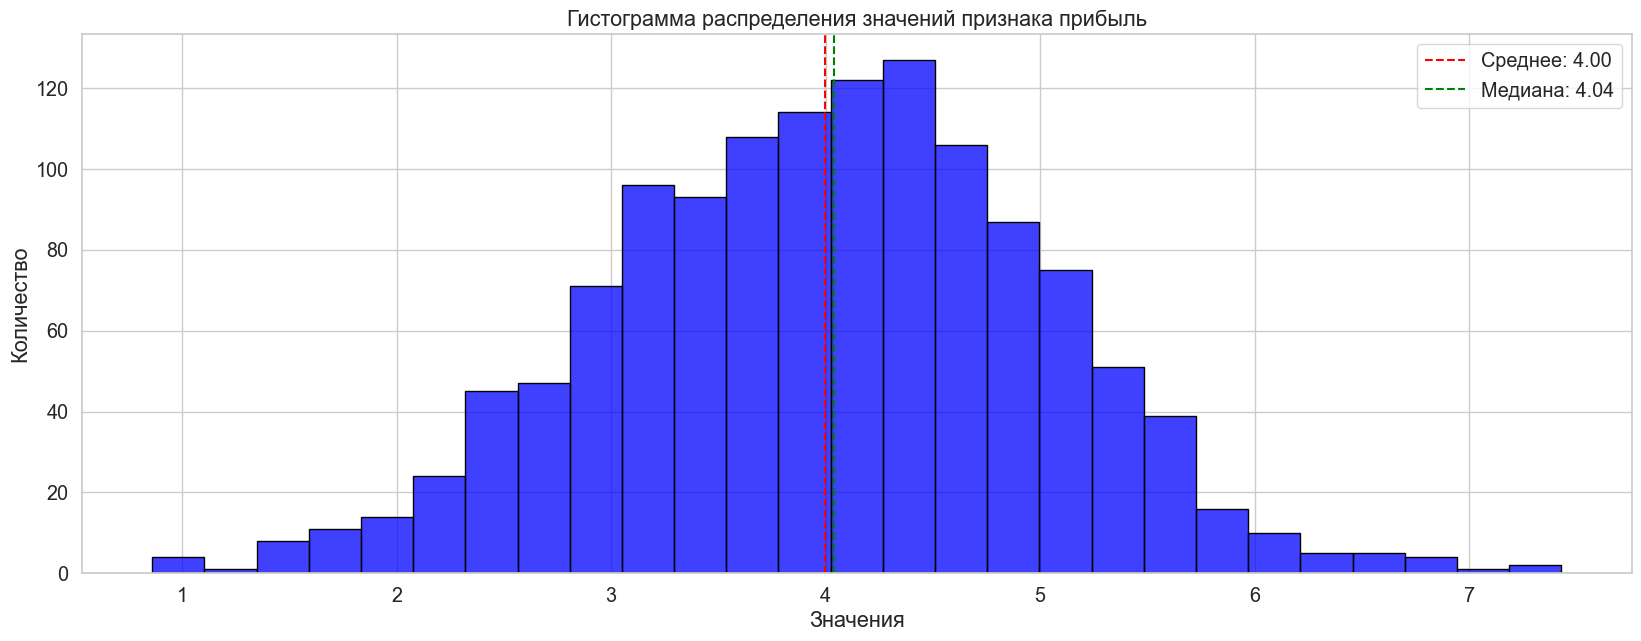

In [46]:
for i in quan_columns:
    # График Boxplot
    market_full.boxplot([i], vert=False, color='blue')
    plt.title('График распределения значений признака '+i)
    plt.xlabel('Значения')
    plt.yticks([1], ['_____'])
    plt.show();

    # Гистограмма
    sns.histplot(market_full[i], color='blue', edgecolor='black')
    plt.title('Гистограмма распределения значений признака '+i)
    plt.axvline(market_full[i].mean(), color='red', linestyle='--', label=f"Среднее: {market_full[i].mean():.2f}")
    plt.axvline(market_full[i].median(), color='green', linestyle='--', label=f"Медиана: {market_full[i].median():.2f}")
    plt.xlabel("Значения")
    plt.ylabel("Количество")
    plt.legend()
    plt.show();

<br><br>
<span style="color:green;">●</span> **3.3 Корректировка количественных данных**

Сразу можно заметить аномалию в признаке "тек_мес_выруч", который сжал весь остальной график признака. Удалим аномалию.

In [49]:
# удаляем строки с 'тек_мес_выруч' > 100000
market_full = market_full[market_full['тек_мес_выруч'] <= 100000]
market_full.reset_index(drop=True, inplace=True)

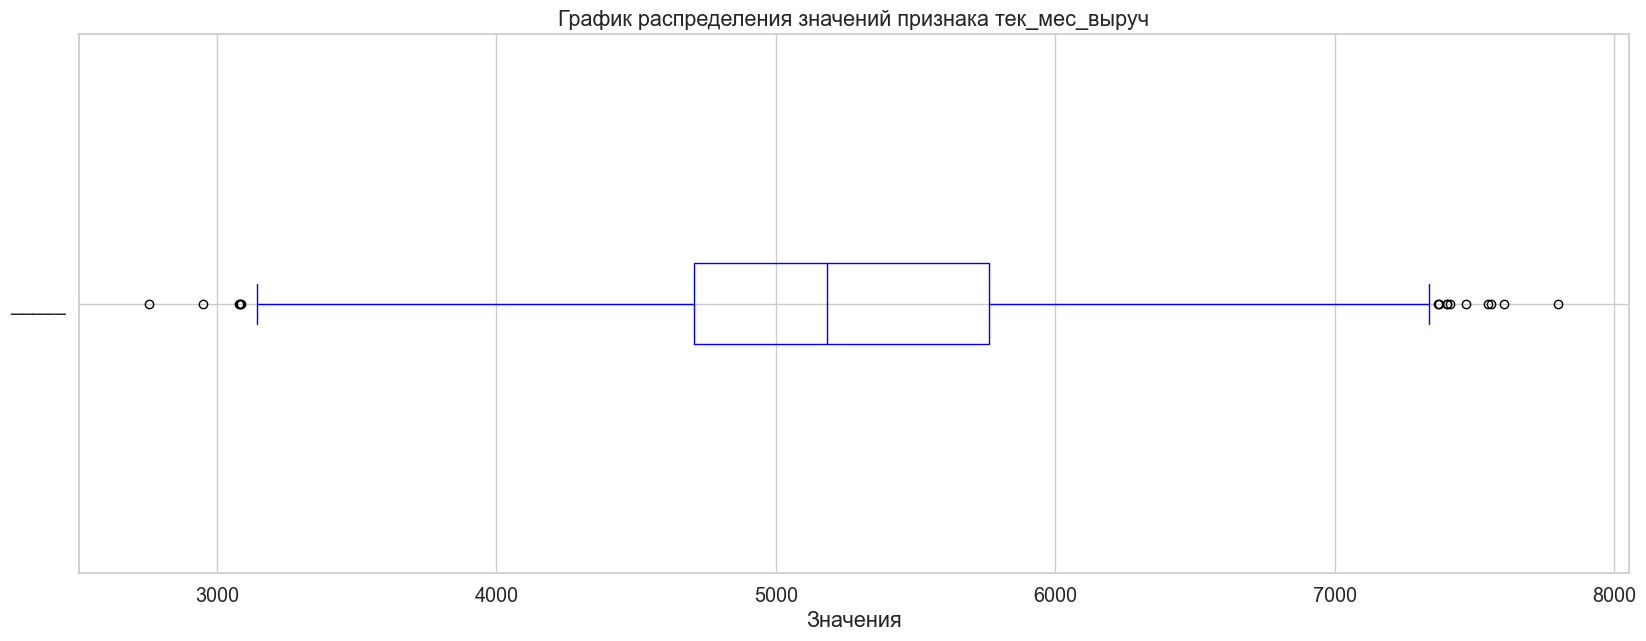

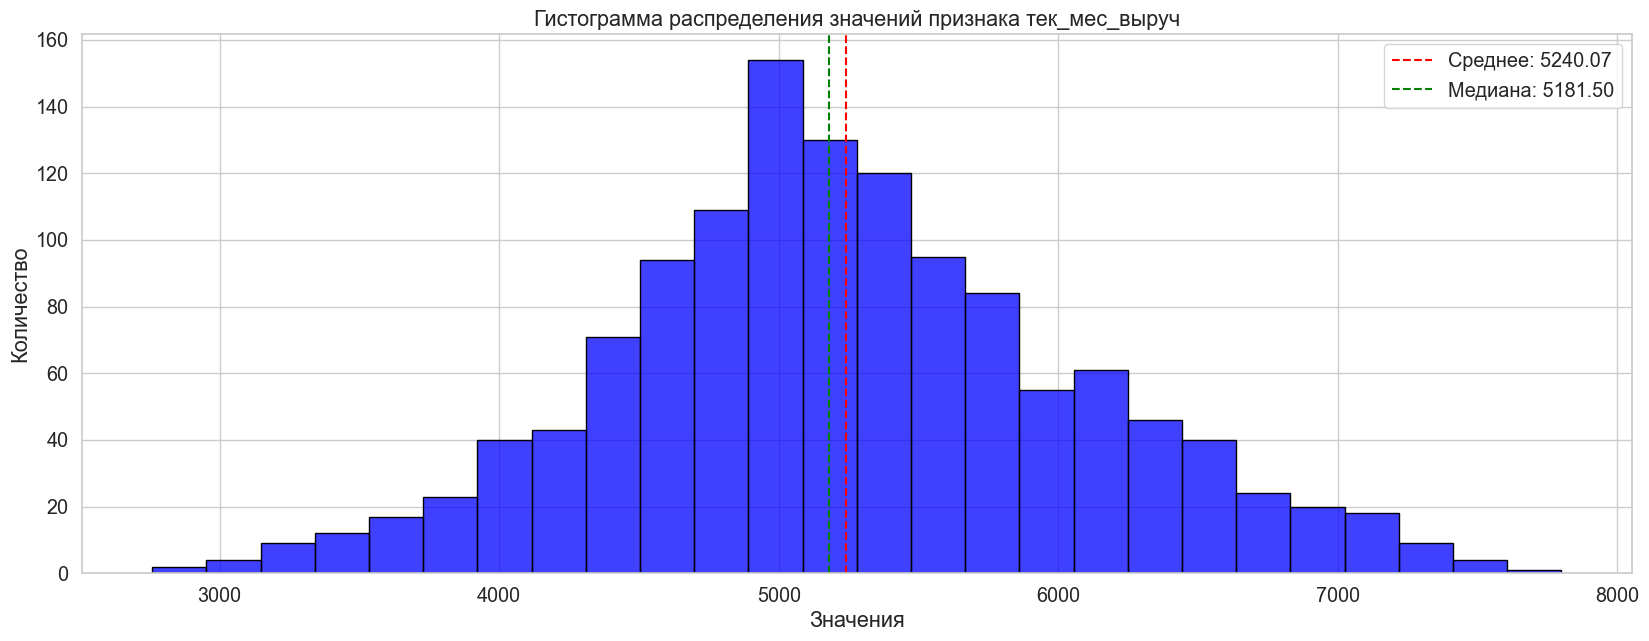

In [50]:
# График Boxplot
market_full.boxplot(['тек_мес_выруч'], vert=False, color='blue')
plt.title('График распределения значений признака тек_мес_выруч')
plt.xlabel('Значения')
plt.yticks([1], ['_____'])
plt.show();

# Гистограмма
sns.histplot(market_full['тек_мес_выруч'], color='blue', edgecolor='black')
plt.title('Гистограмма распределения значений признака тек_мес_выруч')
plt.axvline(market_full['тек_мес_выруч'].mean(), color='red', linestyle='--', label=f"Среднее: {market_full['тек_мес_выруч'].mean():.2f}")
plt.axvline(market_full['тек_мес_выруч'].median(), color='green', linestyle='--', label=f"Медиана: {market_full['тек_мес_выруч'].median():.2f}")
plt.xlabel("Значения")
plt.ylabel("Количество")
plt.legend()
plt.show();

<br><br>
<span style="color:green;">●</span> **3.4 Статистические данные**

In [52]:
display(market_full.describe())

,маркетактив_6_мес,маркетактив_тек_мес,длит_ть,акц_покупки,просм_катег_за_визит_сред,неоплач_продукт_квартал_шт,ошибка_сервис,страниц_за_визит,пред_мес_мин,тек_мес_мин,препред_мес_выруч,пред_мес_выруч,тек_мес_выруч,прибыль
count,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000
mean,4.253541,4.007004,602.914397,0.320420,3.277043,2.840467,4.185992,8.175875,13.453696,13.207782,4836.206226,4949.841245,5240.072140,3.995984
std,1.015195,0.696530,249.258312,0.249397,1.355551,1.972217,1.951624,3.976004,3.941995,4.216449,333.405071,700.263256,836.099168,1.010770
min,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,4098.000000,2890.000000,2758.700000,0.860000
25%,3.700000,4.000000,408.000000,0.170000,2.000000,1.000000,3.000000,5.000000,10.000000,10.000000,4586.000000,4497.000000,4707.300000,3.300000
50%,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000,13.000000,13.000000,4809.000000,5007.000000,5181.500000,4.040000
75%,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000,16.000000,16.000000,5053.000000,5414.000000,5763.000000,4.670000
max,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,23.000000,23.000000,5663.000000,6869.500000,7799.400000,7.430000


<br><br>
<span style="color:green;">●</span> **3.5 Исследовательский анализ категориальных данных**.

In [54]:
cat_columns = [
    'покупактив', 
    'тип_сервис', 
    'разр_сообщать', 
    'попул_катег',
    'маркетактив_тек_мес', 
    'просм_катег_за_визит_сред', 
    'неоплач_продукт_квартал_шт', 
    'ошибка_сервис'
]

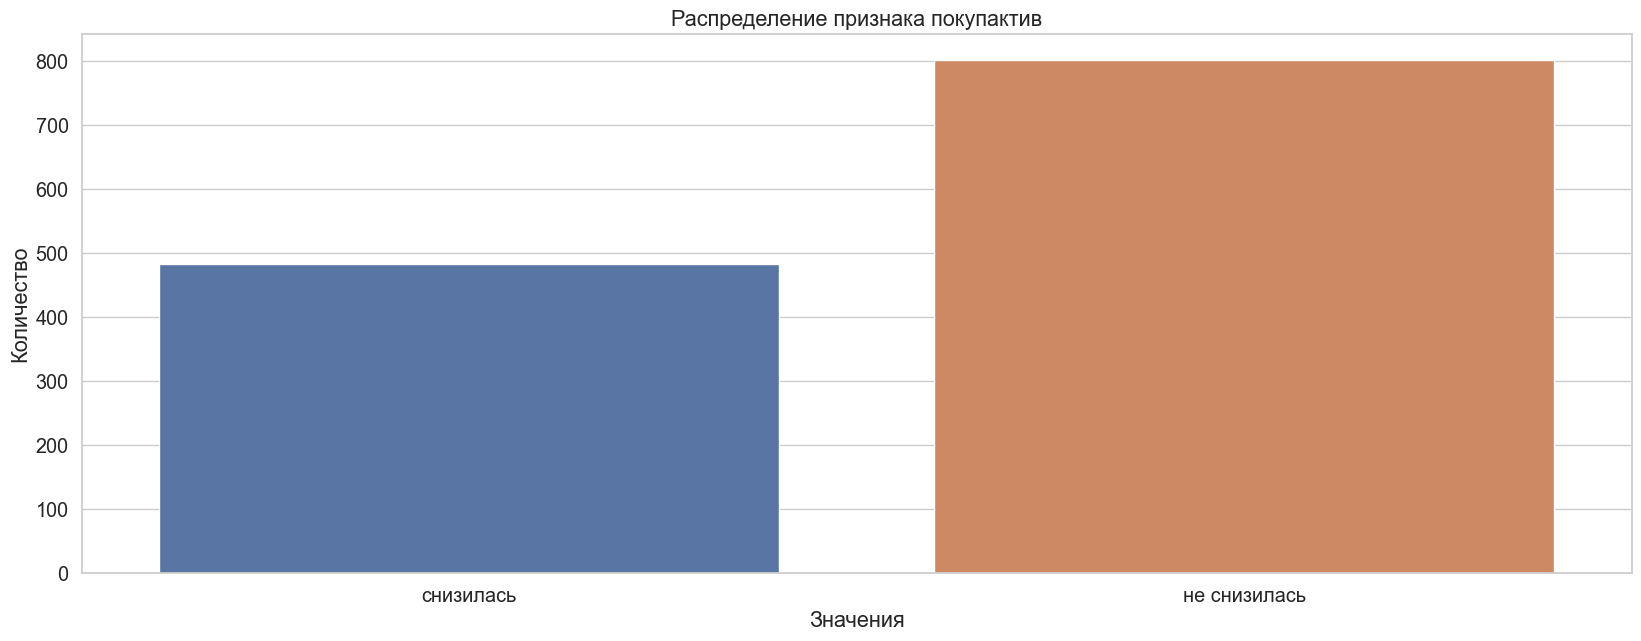

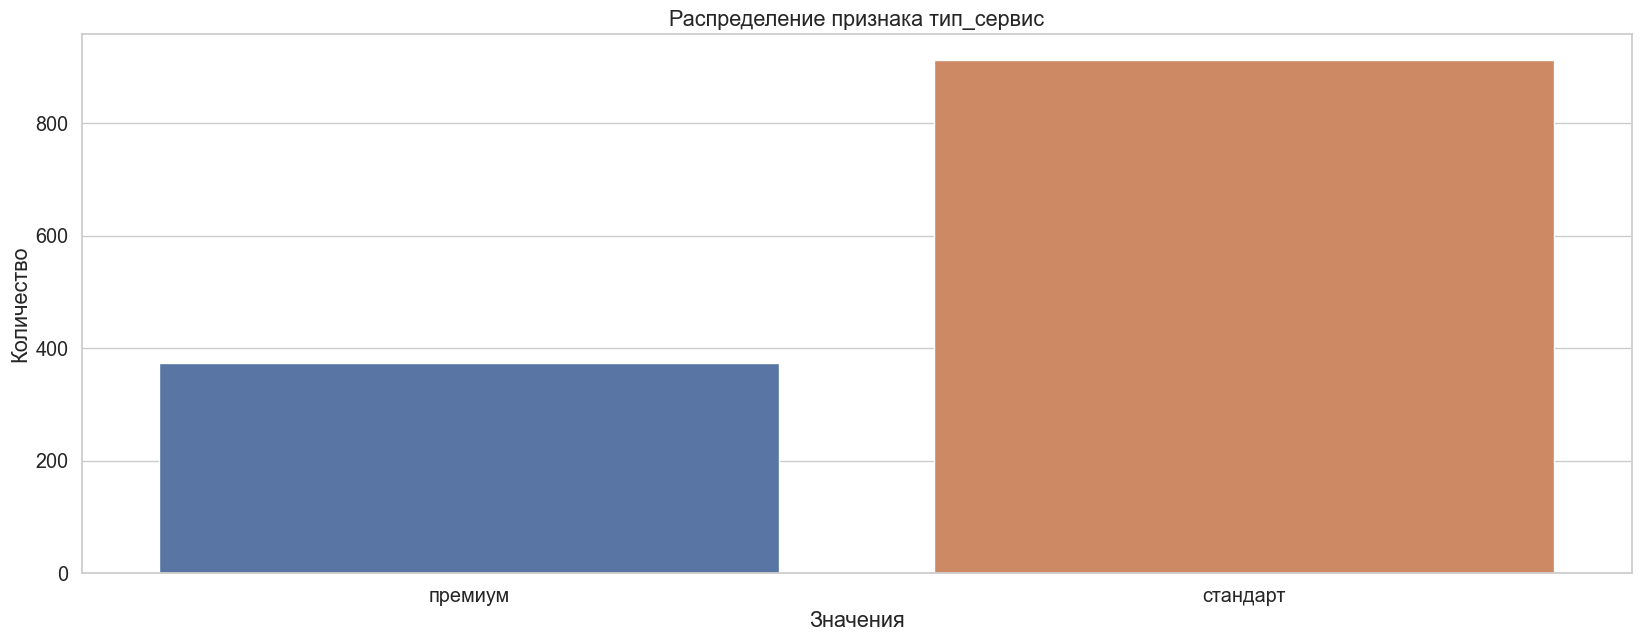

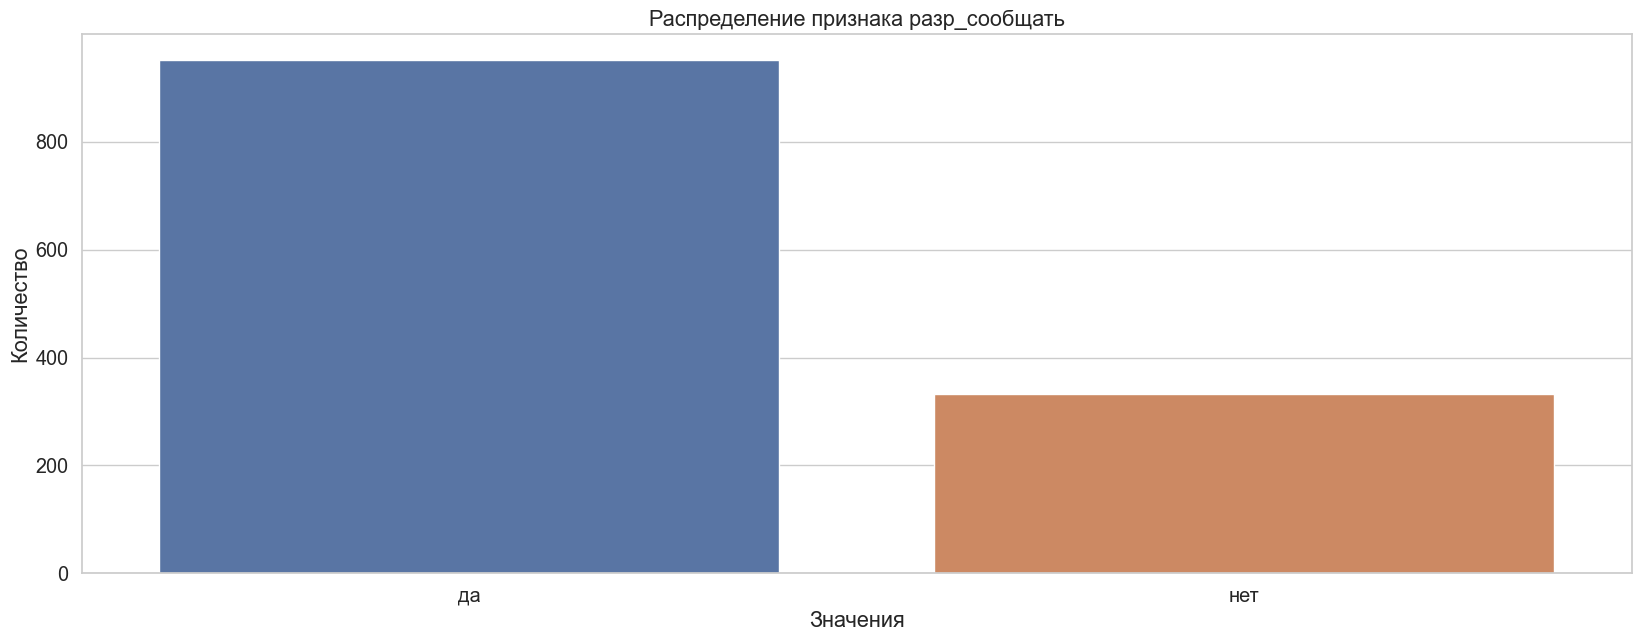

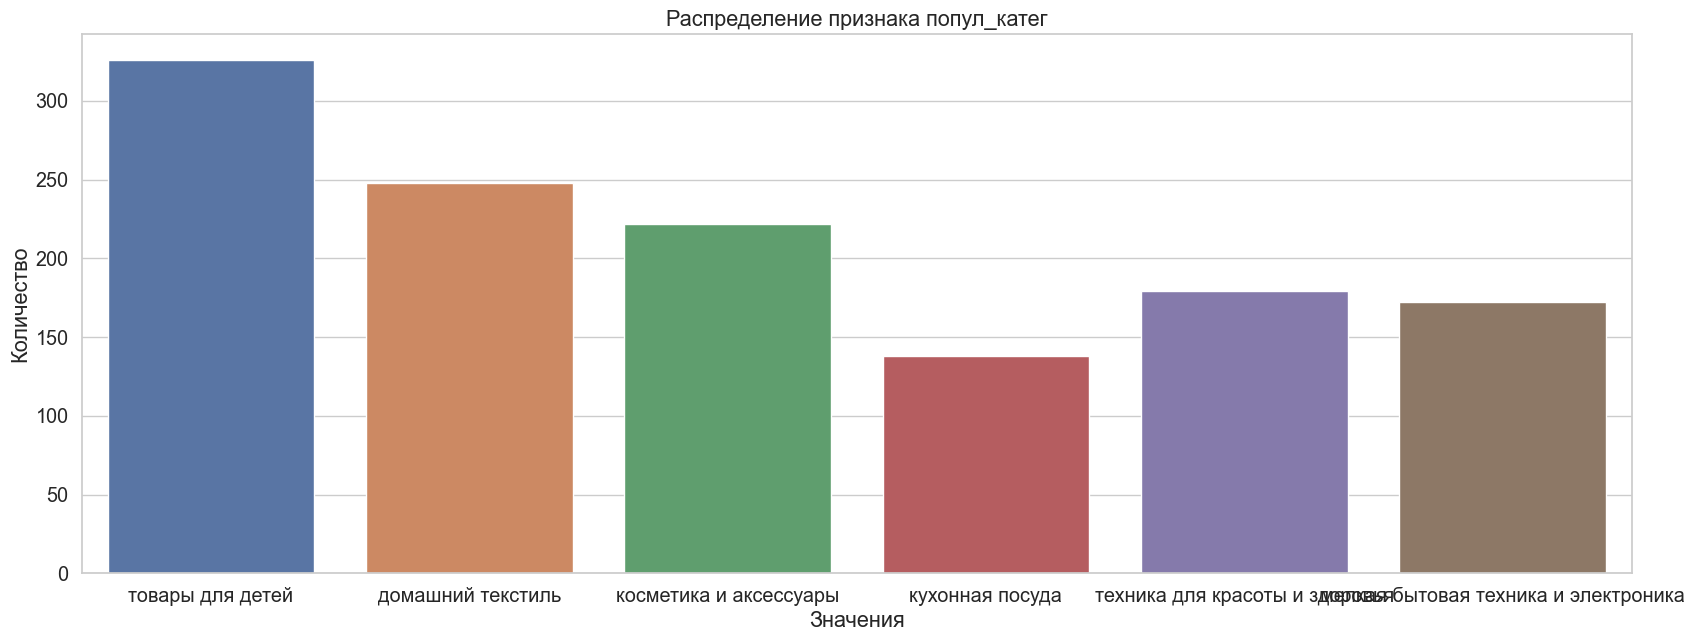

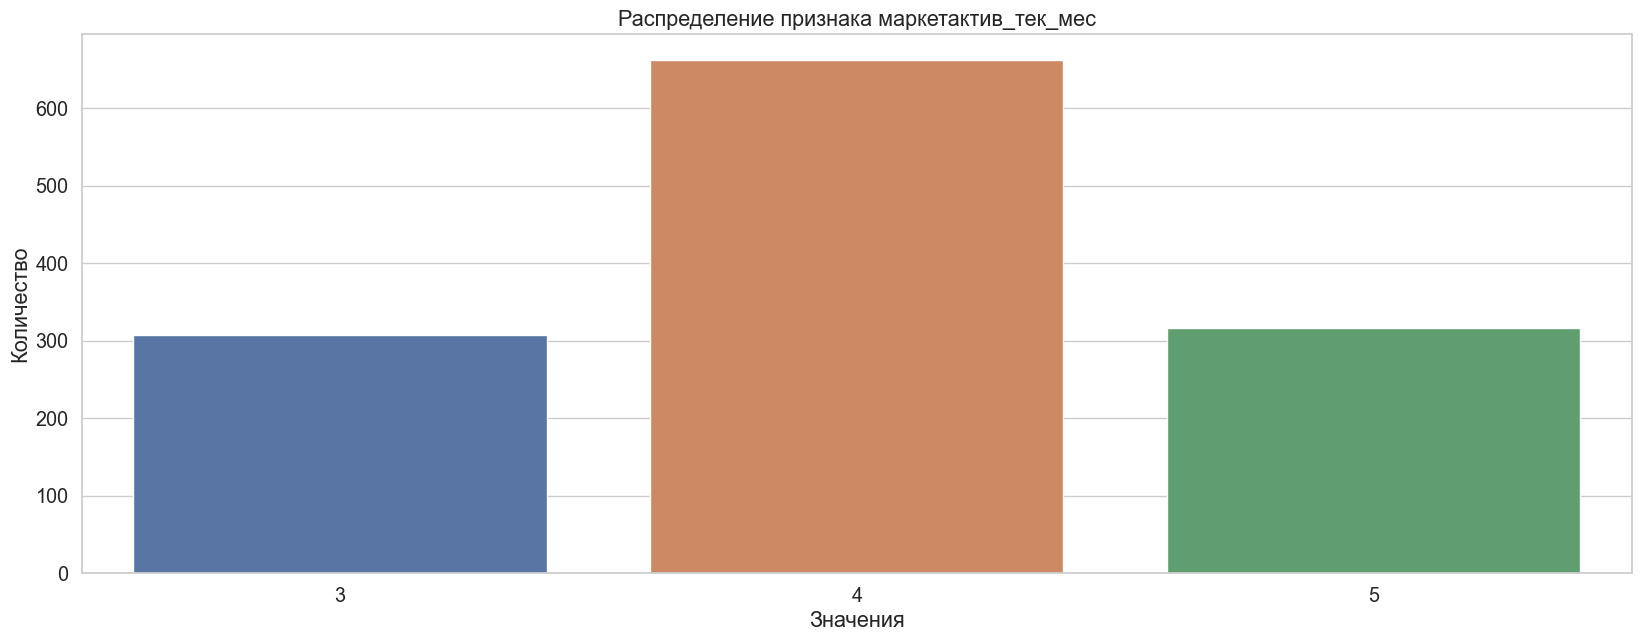

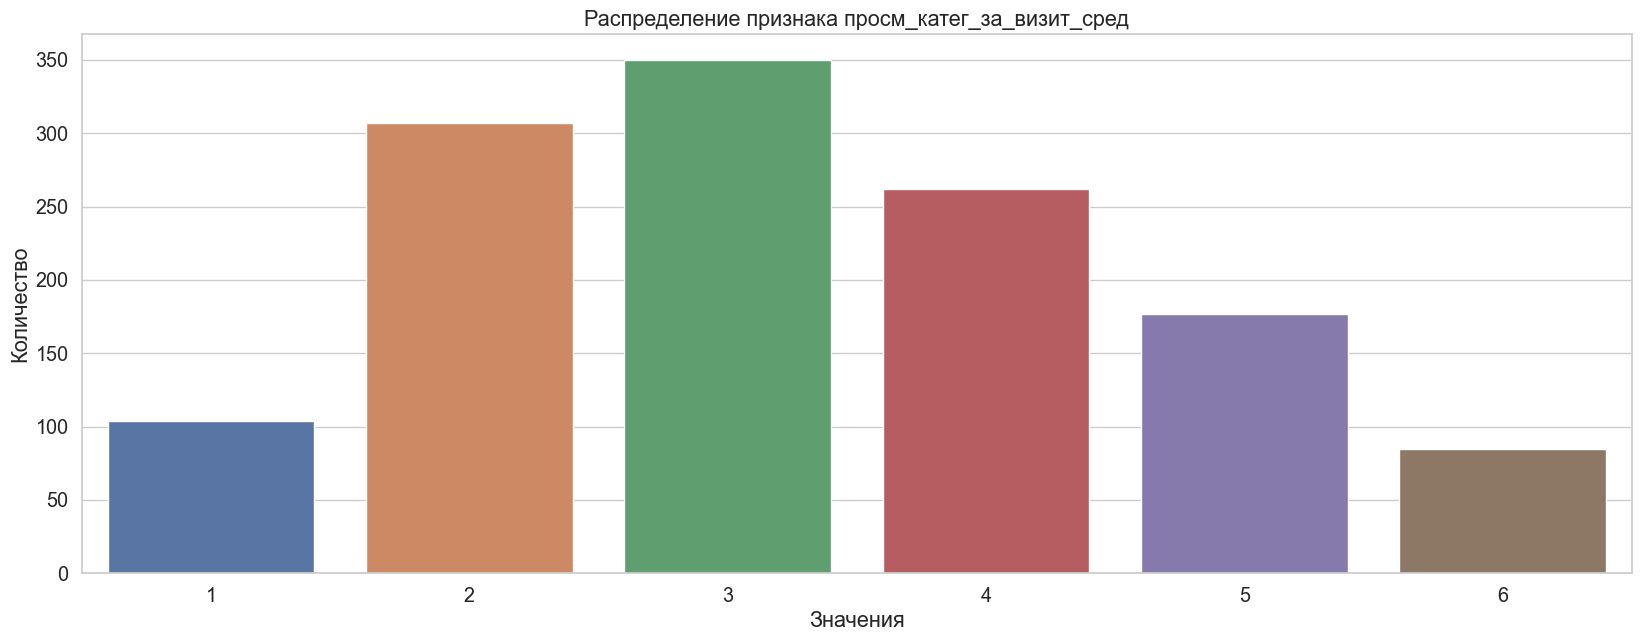

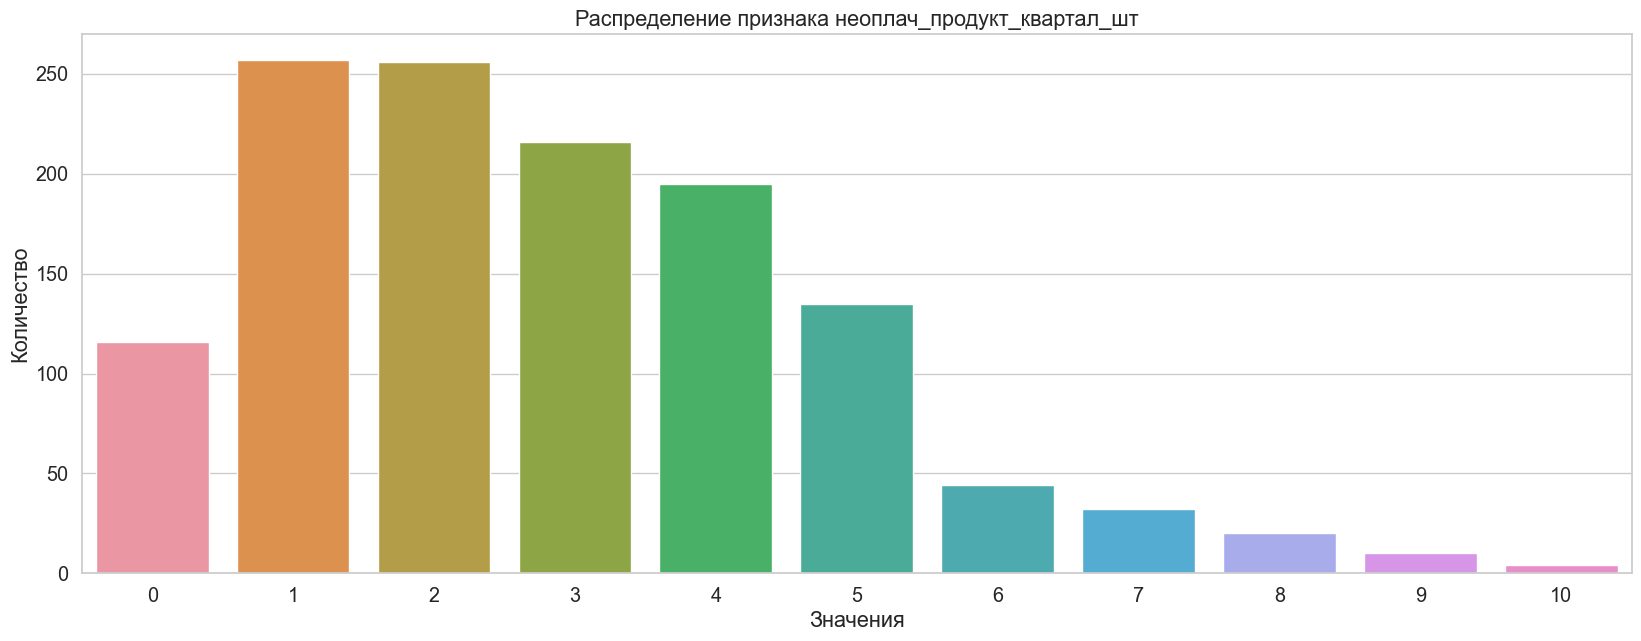

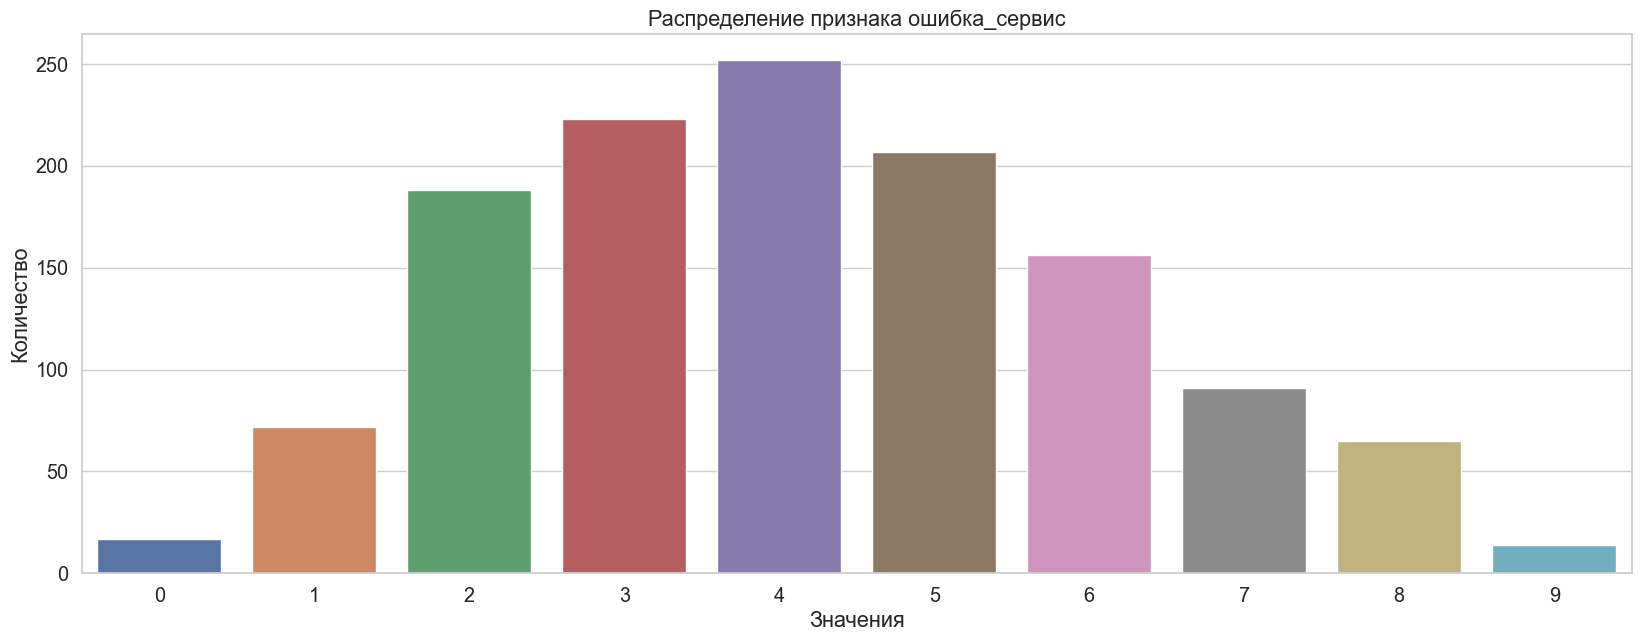

In [55]:
for y in cat_columns:
    sns.countplot(x=market_full[y])
    plt.title(f"Распределение признака {y}")
    plt.xlabel("Значения")
    plt.ylabel("Количество")
    plt.show()

<br><br>
<span style="color:green;">●</span> **3.6 Выводы по шагу 3**.

-

<br><br>
# Шаг 4. Корреляционный анализ данных

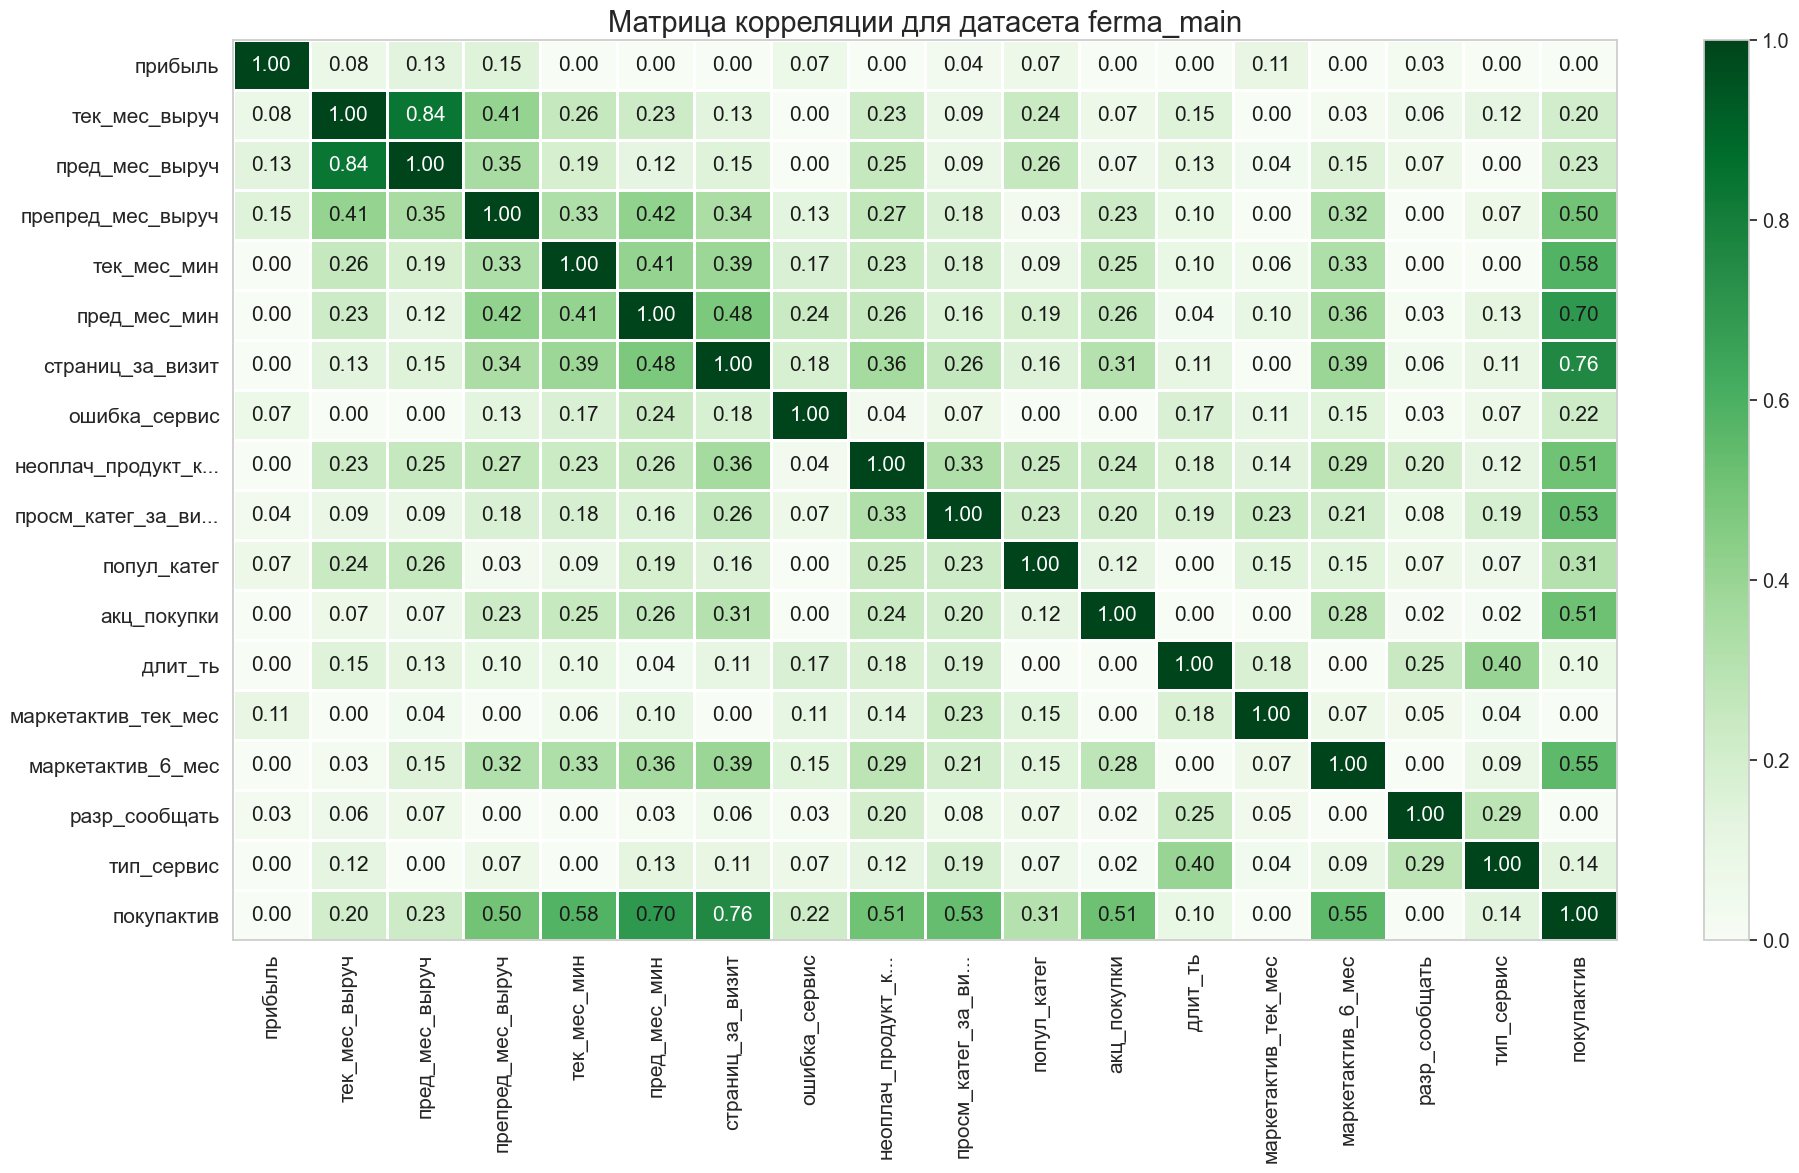

In [58]:
phik_overview = phik_matrix(market_full, interval_cols=['маркетактив_6_мес', 'маркетактив_тек_мес', 'длит_ть', 'акц_покупки', \
                                                        'просм_катег_за_визит_сред', 'неоплач_продукт_квартал_шт', 'ошибка_сервис', \
                                                       'страниц_за_визит', 'пред_мес_мин', 'тек_мес_мин', 'препред_мес_выруч', \
                                                       'пред_мес_выруч', 'тек_мес_выруч', 'прибыль'])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции для датасета ferma_main',
    fontsize_factor=1.5,
    figsize=(20, 12)
)

<br><br>
# Шаг 5. Использование пайплайнов

<br><br>
<span style="color:green;">●</span> **5.1 Определение категории признаков для кодирования и масштабирования**.

In [60]:
# два кодировщика

ohe_columns = ['разр_сообщать', 'попул_катег']

ord_columns = ['тип_сервис']

# два масштабатора

stand_columns = [
    'маркетактив_6_мес', 
    'длит_ть',
    'страниц_за_визит', 
    'пред_мес_мин', 
    'тек_мес_мин', 
    'препред_мес_выруч',
    'пред_мес_выруч', 
    'тек_мес_выруч', 
    'маркетактив_тек_мес',
    'просм_катег_за_визит_сред',
    'неоплач_продукт_квартал_шт',
    'ошибка_сервис'
]

minmax_columns = ['акц_покупки']

<br><br>
<span style="color:green;">●</span> **5.2 Объединение кодирования и мастабирования**.

In [61]:
data_preprocessor = ColumnTransformer([
    
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_columns),
    
    ('ord', OrdinalEncoder(
        categories=[['стандарт', 'премиум']],
        handle_unknown='use_encoded_value', unknown_value=-1
    ), ord_columns),
    
    ('stand', StandardScaler(), stand_columns),
    
    ('minmax', MinMaxScaler(), minmax_columns)
    
])

data_preprocessor

ColumnTransformer(transformers=[('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['разр_сообщать', 'попул_катег']),
                                ('ord',
                                 OrdinalEncoder(categories=[['стандарт',
                                                             'премиум']],
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['тип_сервис']),
                                ('stand', StandardScaler(),
                                 ['маркетактив_6_мес', 'длит_ть',
                                  'страниц_за_визит', 'пред_мес_мин',
                                  'тек_мес_мин', 'препред_мес_выруч',
                                  'пред_мес_выруч', 'тек_мес_выруч',
                                  'маркетактив_тек_мес',
                                  'просм_катег_за_визит_сред',
                                  'неоплач_продукт_квартал_шт',
                                  'ошибка_сервис']),
                                ('minmax', MinMaxScaler(), ['акц_покупки'])])

<br><br>
<span style="color:green;">●</span> **5.3 Создание итогового пайплайна с моделью-заглушкой**.

In [62]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=17))
])

pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['разр_сообщать',
                                                   'попул_катег']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['стандарт',
                                                                              'премиум']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['тип_сервис']),
                                                 ('stand', StandardScaler(),
                                                  ['маркетактив_6_мес',
                                                   'длит_ть',
                                                   'страниц_за_визит',
                                                   'пред_мес_мин',
                                                   'тек_мес_мин',
                                                   'препред_мес_выруч',
                                                   'пред_мес_выруч',
                                                   'тек_мес_выруч',
                                                   'маркетактив_тек_мес',
                                                   'просм_катег_за_визит_сред',
                                                   'неоплач_продукт_квартал_шт',
                                                   'ошибка_сервис']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['акц_покупки'])])),
                ('models', DecisionTreeClassifier(random_state=17))])

<br><br>
<span style="color:green;">●</span> **5.4 Определение моделей с гиперпараметрами для перебора**.

In [63]:
param_grid = [
    # Гиперпараметры для модели DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=17)],
        'models__max_depth': range(2, 10),
        'models__max_features': ['sqrt', 'log2', None],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 5, 10],
        'models__criterion': ['gini', 'entropy'],
        'preprocessor__stand': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__minmax': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # Гиперпараметры для модели KNeighborsClassifier
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'models__weights': ['uniform', 'distance'],
        'models__metric': ['euclidean', 'manhattan', 'minkowski'],
        'preprocessor__stand': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__minmax': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # Гиперпараметры для модели LogisticRegression
    {
        'models': [LogisticRegression(random_state=17, solver='liblinear')],
        'models__C': [0.1, 1, 10, 100],
        'models__penalty': ['l1', 'l2'],
        'preprocessor__stand': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__minmax': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # Гиперпараметры для модели SVC
    {
        'models': [SVC(random_state=17)],
        'models__C': [0.1, 1, 10, 100],
        'models__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
        'models__gamma': ['scale', 'auto', 0.1, 1],
        'models__degree': range(2, 5),
        'preprocessor__stand': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__minmax': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

<br><br>
<span style="color:green;">●</span> **5.5 Автоматизированный поиск гиперпараметров**.

In [64]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=17,
    n_jobs=-1
)

randomized_search

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['разр_сообщать',
                                                                                'попул_катег']),
                                                                              ('ord',
                                                                               OrdinalEncoder(categories=[['стандарт',
                                                                                                           'премиум']],
                                                                                              handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['тип_сервис']),
                                                                              ('stand',
                                                                               Stan...
                                        {'models': [SVC(random_state=17)],
                                         'models__C': [0.1, 1, 10, 100],
                                         'models__degree': range(2, 5),
                                         'models__gamma': ['scale', 'auto', 0.1,
                                                           1],
                                         'models__kernel': ['linear', 'rbf',
                                                            'sigmoid', 'poly'],
                                         'preprocessor__minmax': [StandardScaler(),
                                                                  MinMaxScaler(),
                                                                  'passthrough'],
                                         'preprocessor__stand': [StandardScaler(),
                                                                 MinMaxScaler(),
                                                                 'passthrough']}],
                   random_state=17, scoring='roc_auc')

<br><br>
<span style="color:green;">●</span> **5.6 Подготовка данных для обучения модели**.

In [65]:
market_full['покупактив'] = market_full['покупактив'].apply(lambda x: 1 if x == 'снизилась' else 0)

# определяем целевой и входные данные

X = market_full.drop(['прибыль', 'покупактив'], axis=1)                          
y = market_full['покупактив']

# разделяем на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(
    X,                          
    y,
    test_size = 0.25, 
    random_state = 17,
    stratify = y
)

<br><br>
<span style="color:green;">●</span> **5.7 Обучение модели на тренировочных данных**.

In [66]:
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['разр_сообщать',
                                                   'попул_катег']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['стандарт',
                                                                              'премиум']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['тип_сервис']),

<br><br>
<span style="color:green;">●</span> **5.8 Определение метрики на тестовых данных и итоговый вывод**.

In [67]:
y_test_pred = randomized_search.best_estimator_.decision_function(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.9109000452284035


<br><br>
# Шаг 6. Анализ важности признаков

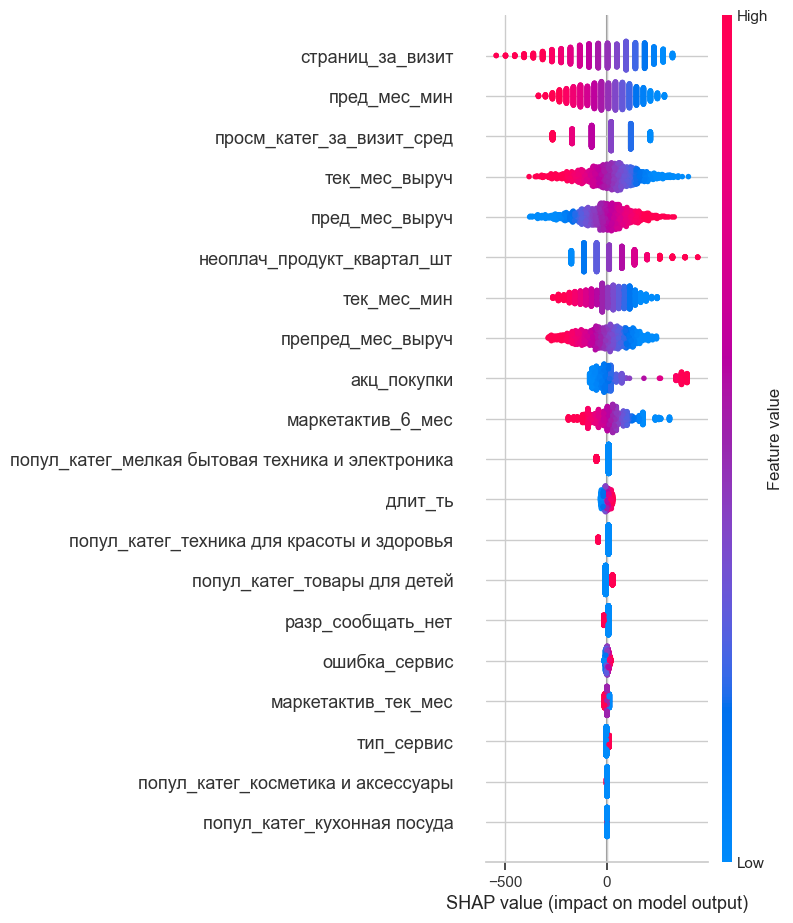

In [69]:
# Обученная модель и pipeline
pipeline = randomized_search.best_estimator_
model = pipeline.named_steps['models']  # Извлечение модели SVC из Pipeline

# Предобработка данных
X_processed = pipeline.named_steps['preprocessor'].transform(X)

# Восстановление названий признаков
preprocessor = pipeline.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out(input_features=X.columns)

# Упрощение имен признаков
simplified_feature_names = [
    name.split("__")[-1] for name in feature_names
]

# Создание DataFrame для обработанных данных с упрощенными названиями признаков
X_processed_df = pd.DataFrame(X_processed, columns=simplified_feature_names)

# Создание объяснителя SHAP
explainer = shap.Explainer(model, X_processed)

# Вычисление SHAP-значений
shap_values = explainer(X_processed)

# Прямое добавление имен признаков в SHAP
for i, shap_array in enumerate(shap_values.values):
    shap_values[i].feature_names = simplified_feature_names

# Построение графика важности признаков
shap.summary_plot(shap_values, X_processed_df, feature_names=simplified_feature_names, show=True)

На основании предоставленного графика SHAP можно сделать следующие выводы:

	1.	Наиболее важные признаки:
	•	Признаки в верхней части графика оказывают наибольшее влияние на предсказания модели.
	•	Самыми важными являются:
	•	страниц_за_визит
	•	пред_мес_мин
	•	просм_катег_за_визит_сред
	•	тек_мес_выруч
	•	пред_мес_выруч
	2.	Влияние значений признаков:
	•	Цветовая шкала (от синего к розовому) показывает значения признаков:
	•	Синий цвет: низкие значения признаков.
	•	Розовый цвет: высокие значения признаков.
	•	Например, для признака страниц_за_визит высокие значения (розовые точки) увеличивают вероятность положительного предсказания, а низкие значения (синие точки) уменьшают её.
	3.	Распределение влияния:
	•	Каждая точка на графике показывает одно наблюдение (строку) в данных.
	•	Ширина распределения вдоль оси SHAP value показывает, насколько сильно влияние данного признака варьируется для разных наблюдений.
	4.	Значение SHAP value:
	•	Значения на оси X (SHAP value) показывают влияние признака на итоговое предсказание модели.
	•	Положительные значения увеличивают вероятность целевого класса, а отрицательные — уменьшают.
	5.	Менее значимые признаки:
	•	Признаки, расположенные ближе к нижней части графика, имеют меньшее влияние на предсказания модели, например:
	•	попул_катег_кухонная посуда
	•	попул_катег_косметика и аксессуары
	•	тип_сервис

Основные выводы:

	•	Признак страниц_за_визит наиболее значим для модели. Повышение его значения приводит к увеличению вероятности целевого события.
	•	Признаки, связанные с выручкой и минутами использования (например, пред_мес_мин, тек_мес_выруч, пред_мес_выруч), также играют ключевую роль.
	•	Некоторые признаки из категориальных переменных (например, попул_катег) оказывают минимальное влияние.

У признака "тек_мес_выруч" слева от оси - розовые значения, а справа - синие. Правильно ли я понял, что более высокие значения признака склоняют модель к классу 0, а низкие значения - к классу 1?

Да, вы правильно интерпретируете! Если у признака “тек_мес_выруч” наблюдаются:

	•	Розовые значения слева от оси: это означает, что высокая выручка (большие значения) снижает вероятность класса 1 и склоняет модель к предсказанию класса 0.
	•	Синие значения справа от оси: это говорит о том, что низкая выручка (маленькие значения) повышает вероятность класса 1.

In [72]:
columns = [
    'покупактив', 
    'тип_сервис', 
    'разр_сообщать', 
    'попул_катег',
    'маркетактив_тек_мес', 
    'просм_катег_за_визит_сред', 
    'неоплач_продукт_квартал_шт', 
    'ошибка_сервис',
    'маркетактив_6_мес', 
    'длит_ть', 
    'акц_покупки',
    'страниц_за_визит', 
    'пред_мес_мин', 
    'тек_мес_мин', 
    'препред_мес_выруч',
    'пред_мес_выруч', 
    'тек_мес_выруч', 
    'прибыль'
]

for i in columns: 
    print(f' Уникальные значения признака {i}: {market_full[i].unique()} - количество уникальных признаков: {len(market_full[i].unique())}')